# Projet P9 - Produisez une étude de marché avec R ou Python
*OPENCLASSROOMS - Parcours Data Analyst V2 - Adeline Le Ray - Avril 2023*
<hr>

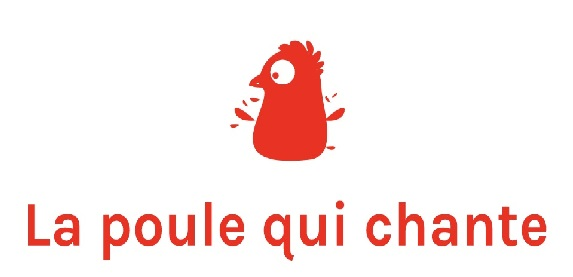

## <font color='blue'>Sommaire</font>

#### *Notebook 1 - Préparation - Nettoyage - Analyse Exploratoire*

* *Partie 1 - Importation et Inspection des fichiers de données*
* *Partie 2 - Préparation et Nettoyage des données*
* *Partie 3 - Analyse Exploratoire (hors ACP)*
* *Partie 4 - Analyse en Composantes Principales*

#### Notebook 2 - Clustering - Visualisation

**[Partie 5 - Clustering ](#partie5)**
* [1. Import des données](#5_1)
    * [1.1. Importation des librairies](#5_1_1)
    * [1.2. Définition des fonctions](#5_1_2)
    * [1.3. Importation des fichiers de données](#5_1_3)
    * [1.4. Analyse en Composantes Principales](#5_1_4)
* [2. Clustering](#5_2)
    * [2.1. Clustering par la méthode de Classification ascendante hiérachique (CAH)](#5_2_1)
    * [2.2. Clustering par la méthode des k-means](#5_2_2)
    * [2.3. Comparaison des résultats des 2 méthodes](#5_2_3)
* [3. Analyse détaillée des clusters](#5_3)
    * [3.1. Localisation géographique](#5_3_1)
    * [3.2. Catégorie de revenu](#5_3_2)
    * [3.3. Population totale des clusters](#5_3_3)
    * [3.4. Analyse par variable](#5_3_4)
* [4. Conclusion et recommandations](#5_4)

# <font color='blue'>Partie 5 - Clustering et visualisations<a class="anchor" id="partie5"></a></font>

## <font color='green'>1. Import des données<a class="anchor" id="5_1"></a></font>

### 1.1. Importation des librairies<a class="anchor" id="5_1_1">

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importation des librairies
import pandas as pd
import numpy as np

from math import pi

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

In [4]:
sns.set()

### 1.2. Définition des fonctions<a class="anchor" id="5_1_2">

In [5]:
# Fonction pour générer un radar plot par ligne du dataframe
def make_spider(data, group, row, title, color):

    # number of variable
    categories=list(data)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # define number of subplot
    if len(data.index)%2 !=0:
        line = round((len(data.index)+1)/2)
    else:
         line = round(len(data.index)/2)
    
    # Initialise the spider plot
    ax = plt.subplot(line,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.ylim(-2.1,2.3)

    # Ind1
    values=data.loc[row].drop(group).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
    
    plt.tight_layout()

### 1.3. Importation des fichiers de données<a class="anchor" id="5_1_3">

In [6]:
df_complet_ok = pd.read_csv('df_complet_ok.csv', index_col=0)

In [7]:
df_complet_ok.head()

c_groupe            groupe  c_zone code_ISO3            zone  c_cont  \
0      5104  Afrique australe     202       ZAF  Afrique du Sud    5100   
1      5104  Afrique australe      20       BWA        Botswana    5100   
2      5104  Afrique australe     209       SWZ        Eswatini    5100   
3      5104  Afrique australe     122       LSO         Lesotho    5100   
4      5104  Afrique australe     147       NAM         Namibie    5100   

  continent  c_income                 income  dispo_interieure_(kt)  ...  \
0   Afrique      9011   4_Pays à haut revenu                 2118.0  ...   
1   Afrique      9011   4_Pays à haut revenu                    7.0  ...   
2   Afrique      5859  2_Pays à revenu moyen                    7.0  ...   
3   Afrique      5859  2_Pays à revenu moyen                   17.0  ...   
4   Afrique      9011   4_Pays à haut revenu                   28.0  ...   

   dispo_prot_(g/pers/j)  part_volaille_dispo_prot    pop_2017  \
0                  14.11                     40.83  57009756.0   
1                   1.19                      4.50   2205080.0   
2                   2.23                     12.32   1124805.0   
3                   2.72                     22.26   2091534.0   
4                   4.25                     18.67   2402633.0   

   Evol_pop_sur_5ans_(%)  stabilite_politique  PIB_hab_($)  \
0               7.326988                -0.28  6723.928582   
1               7.506485                 1.02  6705.339802   
2               4.046657                -0.27  3822.793411   
3               3.659515                -0.19  1061.916962   
4               8.650926                 0.63  5450.334514   

   pop_ss_moyen_alim_saine_(%)  croissance_PIB_(%)  emissions_CO2_(kt)  \
0                         65.2           17.703800         577933.0251   
1                         63.8            6.779399          49992.9993   
2                         74.8           15.343500           1779.2707   
3                         80.2            9.013723           2848.0541   
4                         54.4           20.196593          16979.2766   

   emission_CO2_hab  
0          10137.44  
1          22671.74  
2           1581.85  
3           1361.71  
4           7066.95  

[5 rows x 33 columns]

In [8]:
df = pd.read_csv('df_acp.csv',index_col=0)

In [9]:
df.head()

TAS     TDI    TDC    TCC    TEX  dispo_alim_(kg/pers/an)  \
zone                                                                          
Afrique du Sud  78.71   24.27  54.44  75.73   2.89                    35.69   
Botswana        71.43   42.86  28.57  71.43   0.00                     3.39   
Eswatini        85.71   28.57  57.14  85.71   0.00                     6.46   
Lesotho         11.76   88.24 -76.47  11.76   0.00                     7.93   
Namibie         39.29  103.57 -64.29  -3.57  30.00                    11.53   

                part_volaille_dispo_prot  Evol_pop_sur_5ans_(%)  \
zone                                                              
Afrique du Sud                     40.83               7.326988   
Botswana                            4.50               7.506485   
Eswatini                           12.32               4.046657   
Lesotho                            22.26               3.659515   
Namibie                            18.67               8.650926   

                stabilite_politique  PIB_hab_($)  pop_ss_moyen_alim_saine_(%)  \
zone                                                                            
Afrique du Sud                -0.28  6723.928582                         65.2   
Botswana                       1.02  6705.339802                         63.8   
Eswatini                      -0.27  3822.793411                         74.8   
Lesotho                       -0.19  1061.916962                         80.2   
Namibie                        0.63  5450.334514                         54.4   

                croissance_PIB_(%)  emission_CO2_hab    pop_log  
zone                                                             
Afrique du Sud           17.703800          10137.44  17.858733  
Botswana                  6.779399          22671.74  14.606274  
Eswatini                 15.343500           1581.85  13.933120  
Lesotho                   9.013723           1361.71  14.553408  
Namibie                  20.196593           7066.95  14.692076

In [10]:
df.shape

(170, 14)

### 1.4. Analyse en Composantes Principales<a class="anchor" id="5_1_4">

In [11]:
# Centrage et réduction des variables
X = df.values # Matrice des données
names = df.index # Noms des individus
features = df.columns # Noms des variables

scaler = StandardScaler() # Instanciation du scaler
X_scaled = scaler.fit_transform(X) # Données scalées

In [12]:
# Analyse en Composantes principales
n_components = 6 # Nombre de composantes principales 
pca = PCA(n_components=n_components) # Instanciation de l'ACP
X_proj = pca.fit_transform(X_scaled) # Entraînement et application du modèle sur les données scalées

In [13]:
scree = pd.DataFrame(
    {
        "Dimension" : ["PC" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
scree

Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       PC1            4.190556                  30.0                   30.0
1       PC2            3.182702                  23.0                   52.0
2       PC3            1.773282                  13.0                   65.0
3       PC4            1.025421                   7.0                   72.0
4       PC5            0.990410                   7.0                   79.0
5       PC6            0.922619                   7.0                   86.0

## <font color='green'>2. Clustering <a class="anchor" id="5_2"></a></font>

### 2.1. Clustering par la méthode de Classification ascendante hiérachique (CAH) <a class="anchor" id="5_2_1">

#### 2.1.1. Dendogramme<a class="anchor" id="5_2_1_1">

In [14]:
# Linkage avec la méthode de Ward
Z = linkage(X_proj, method="ward")

Nous observons sur le dendogramme une augmentation des distances entre les valeurs 15 et 20 : cela nous donne un nombre de classes entre 5 et 6.

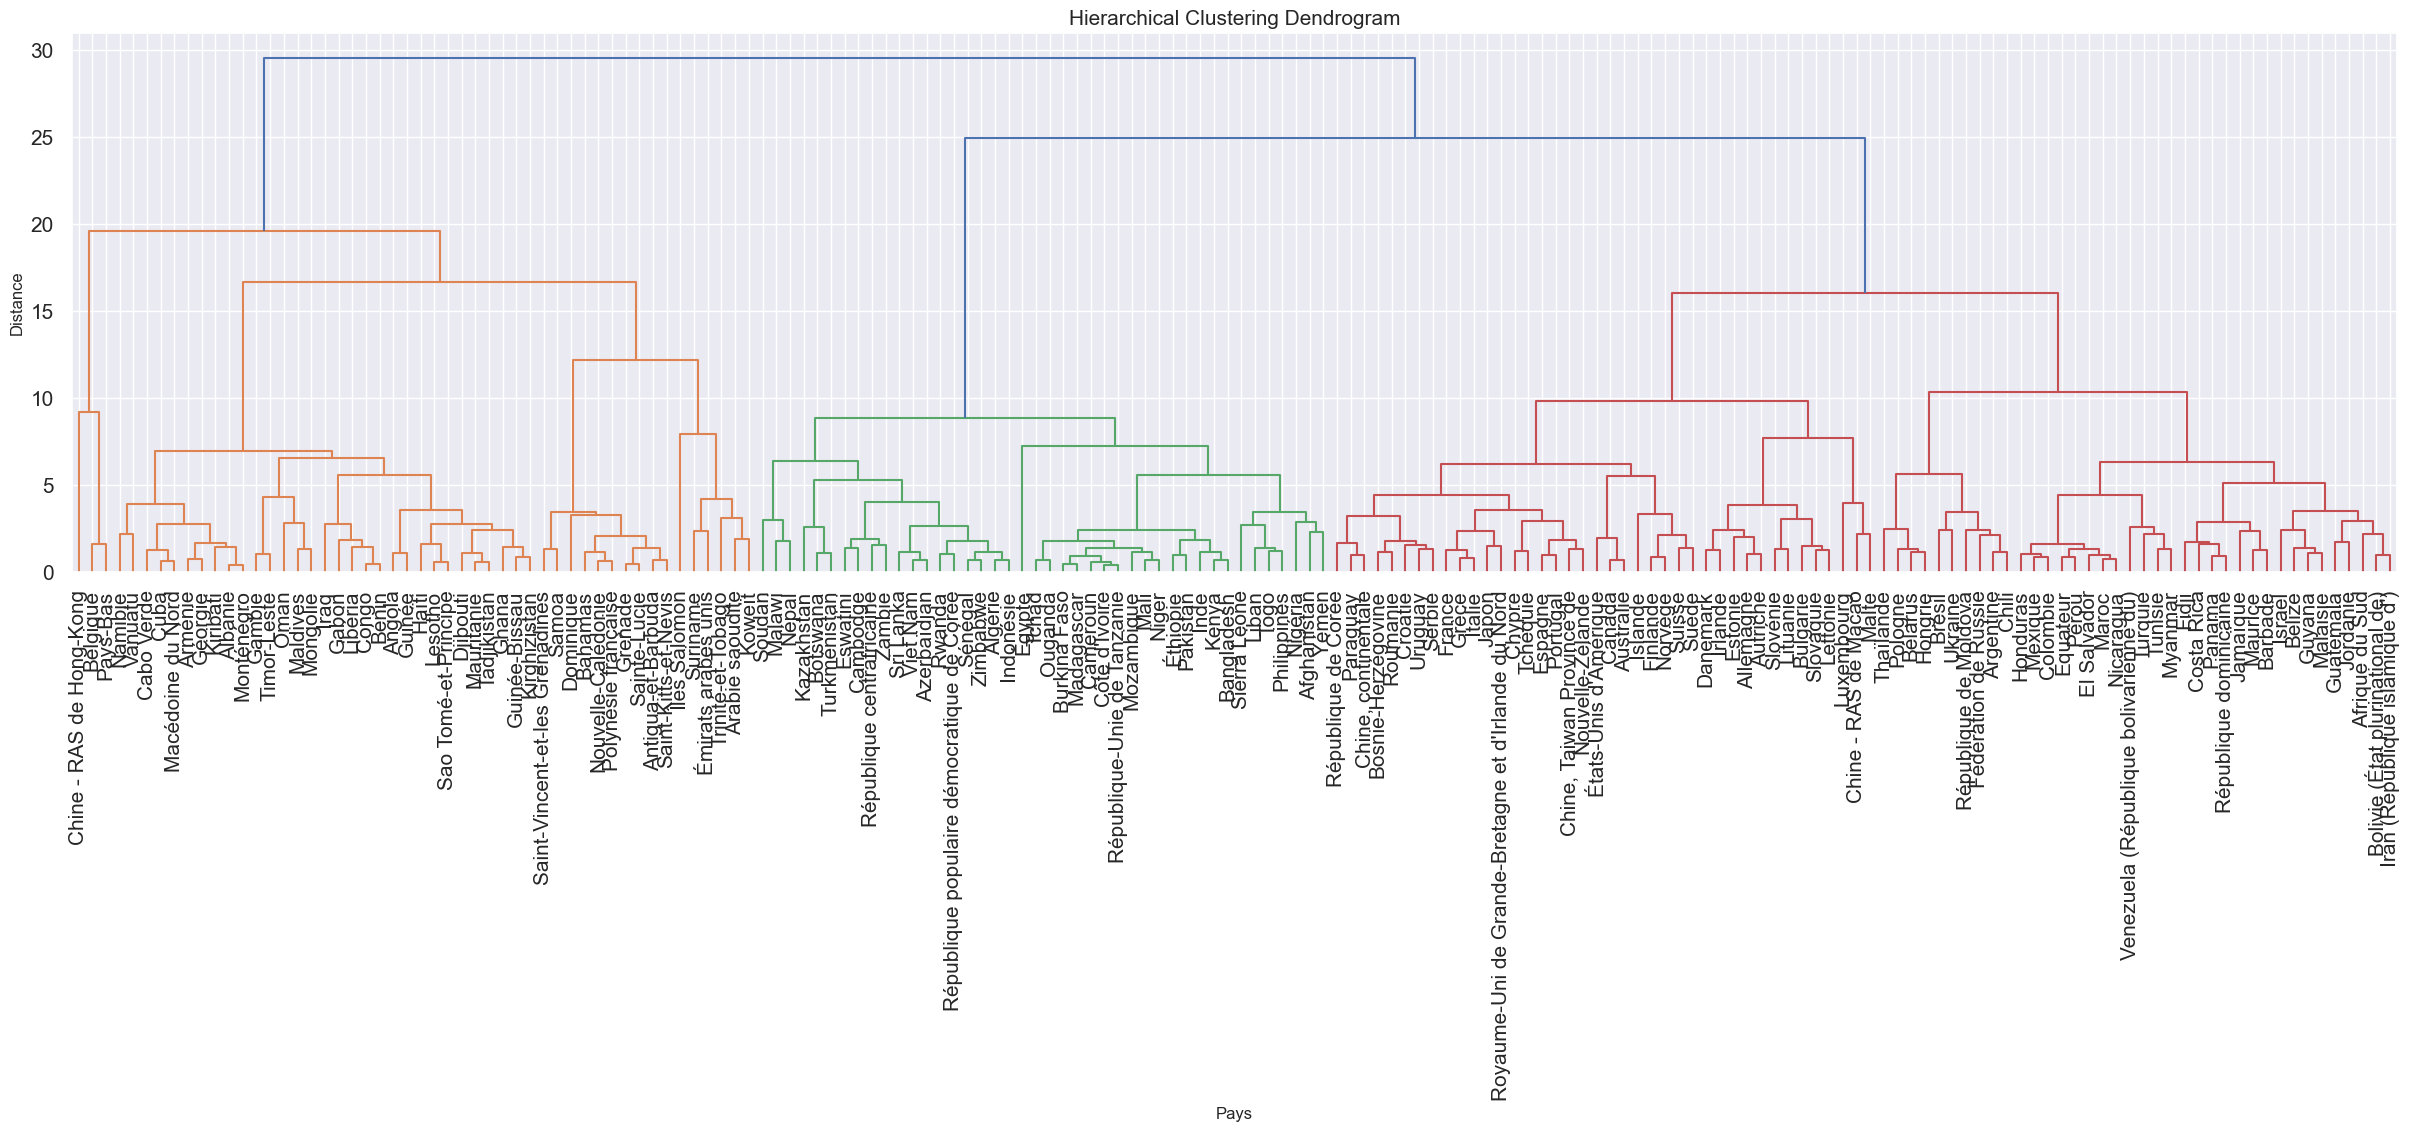

In [15]:
# Affichage du dendrogramme
fig, ax = plt.subplots(1, 1, figsize=(30,7))
dendogram_top = dendrogram(Z, ax=ax, labels=names, orientation='top') 
plt.title("Hierarchical Clustering Dendrogram", fontsize=15)
ax.set_ylabel("Distance")
ax.set_xlabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

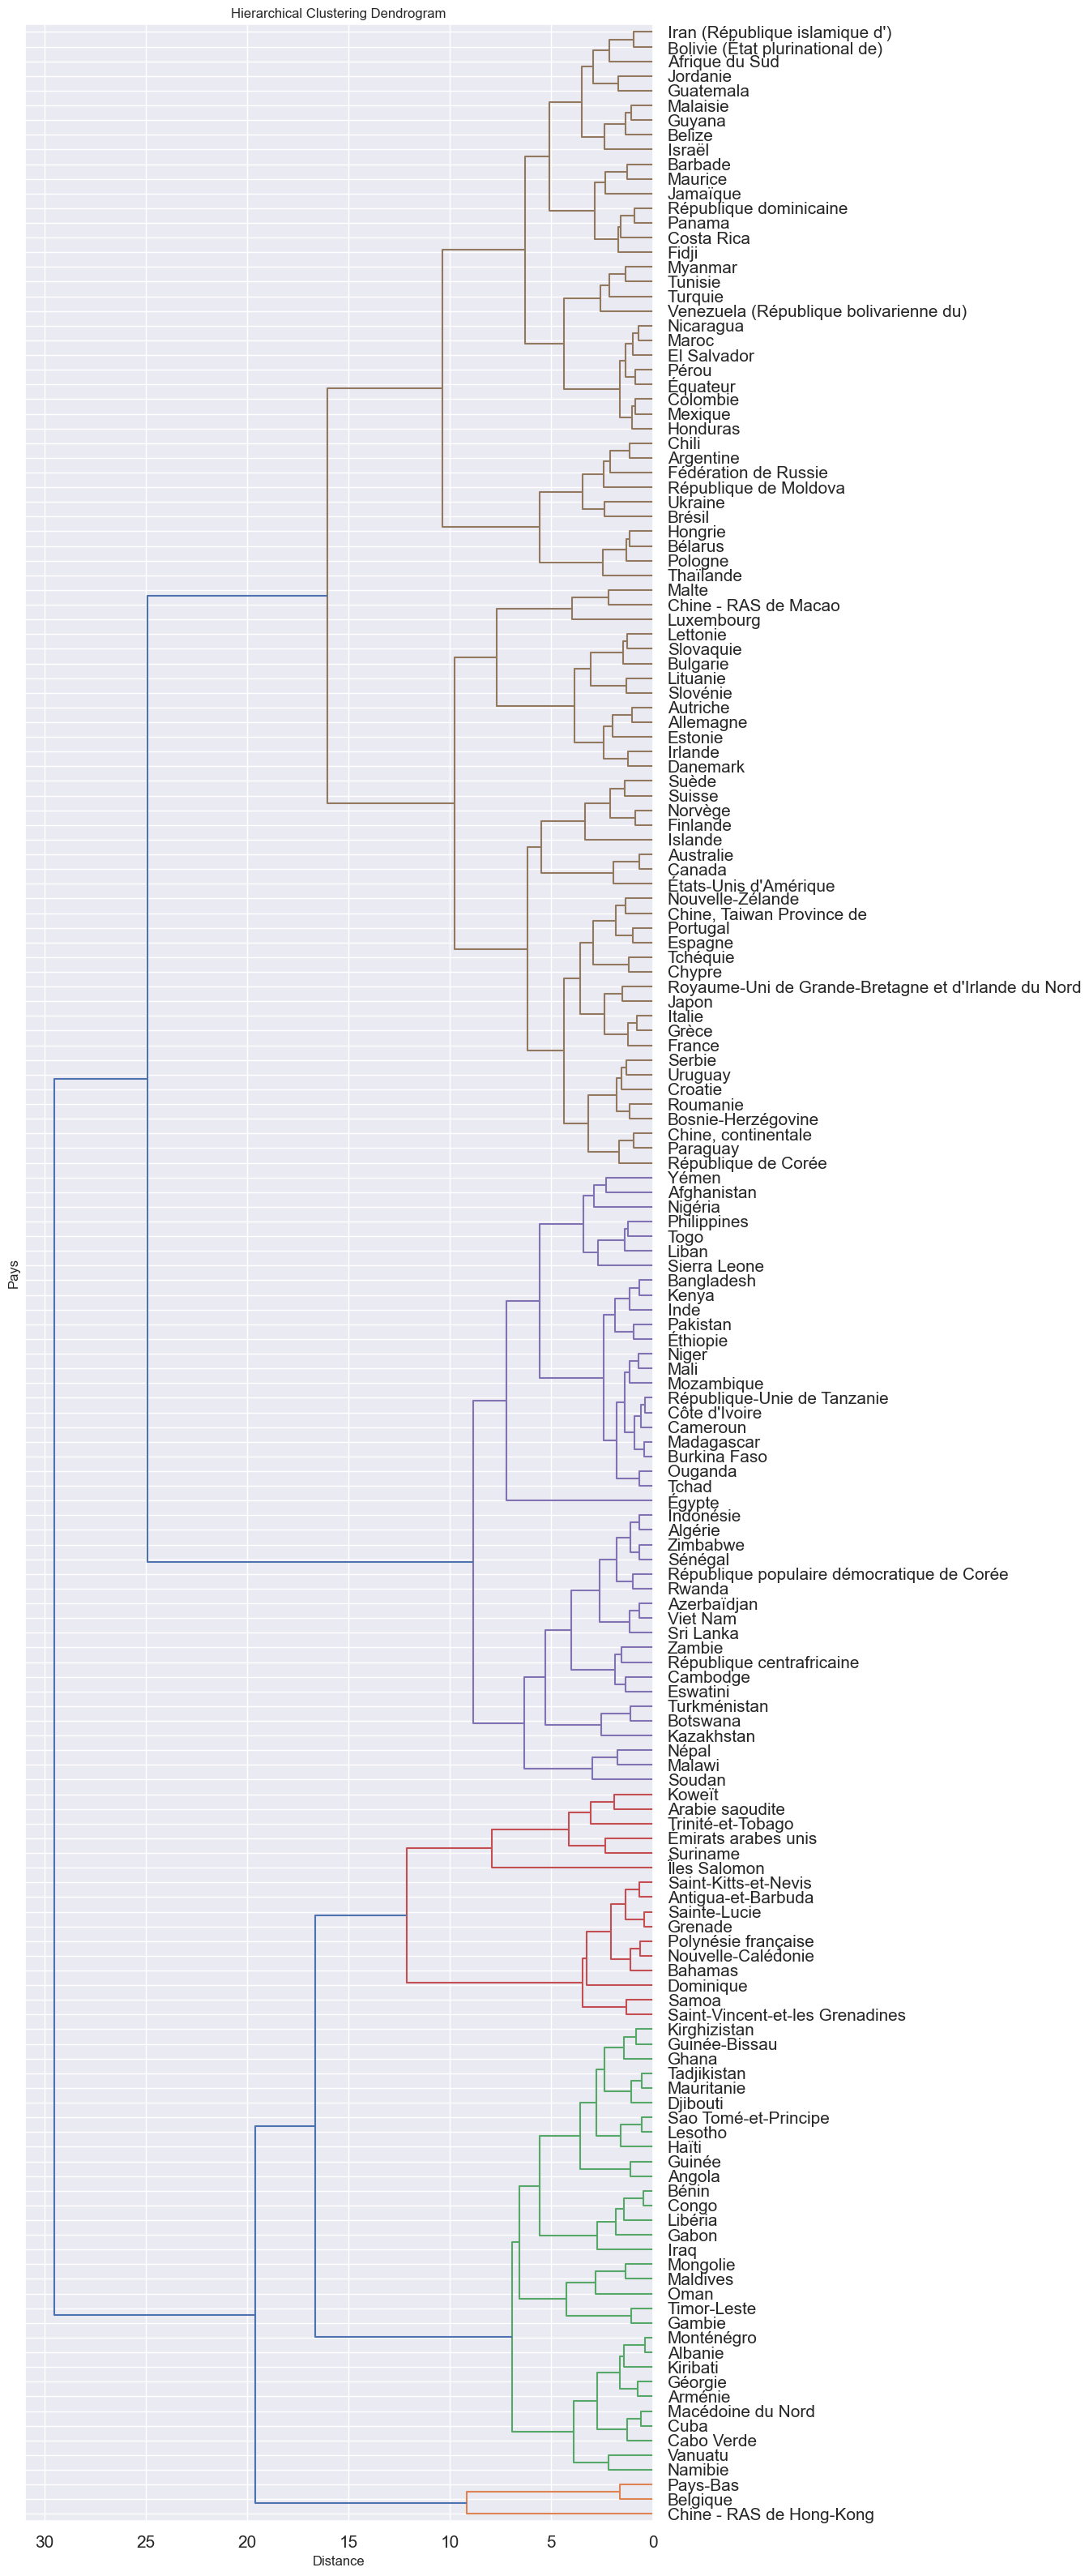

In [16]:
# Affichage du dendrogramme
fig, ax = plt.subplots(1, 1, figsize=(10,40))
# matérialisation des clusters à partir de la hauteur = 16.5
dendrogram_left = dendrogram(Z, ax=ax, labels=names,orientation='left', color_threshold=16.5) 
plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [17]:
# définition du nombre de clusters k
k = 5

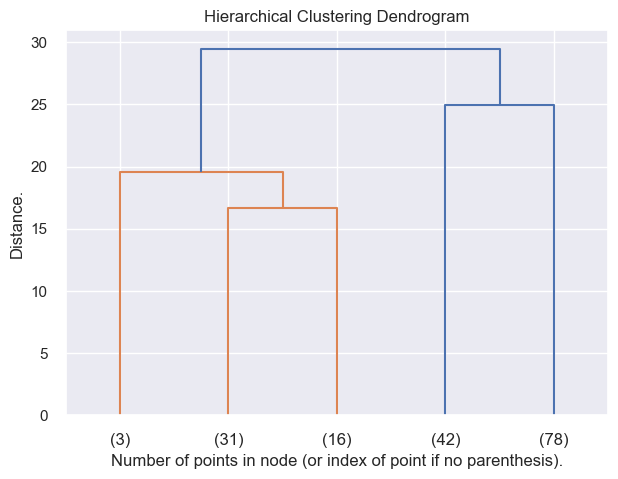

In [18]:
# Affichage du dendrogramme limité à k clusters
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
dendogram_truncate = dendrogram(Z, p=k, truncate_mode="lastp", ax=ax) # découpage pour n'afficher que k clusters
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [19]:
# Définition des clusters
clusters = fcluster(Z, k, criterion='maxclust')

#### 2.1.2. Visualisation des clusters<a class="anchor" id="5_2_1_2">

D'après l'analyse du premier plan factoriel (voir Partie 4), les pays cibles se situent plutôt dans la zone au centre à droite du graphique. Le cluster 3 serait donc le plus intéressant ainsi que certains pays des clusters 1 et 5.

In [20]:
# Coordonnées des centroïdes
centroid_CAH_proj = pd.DataFrame(X_proj)
centroid_CAH_proj['Cluster_CAH'] = clusters
centroid_CAH_proj = centroid_CAH_proj.groupby('Cluster_CAH').mean()
centroid_CAH_proj

0         1         2         3         4         5
Cluster_CAH                                                            
1            4.531103  1.848146  5.758835  2.974772 -0.443737 -1.612519
2            0.971969 -2.343107  0.365483 -0.158263 -0.262246 -0.082979
3            3.350932 -0.505123 -1.526175  0.170695  0.359777 -0.293371
4           -2.283592 -0.949960  0.325961 -0.005120  0.180619  0.140349
5           -0.018313  1.475284 -0.229206 -0.083773 -0.049764  0.079605

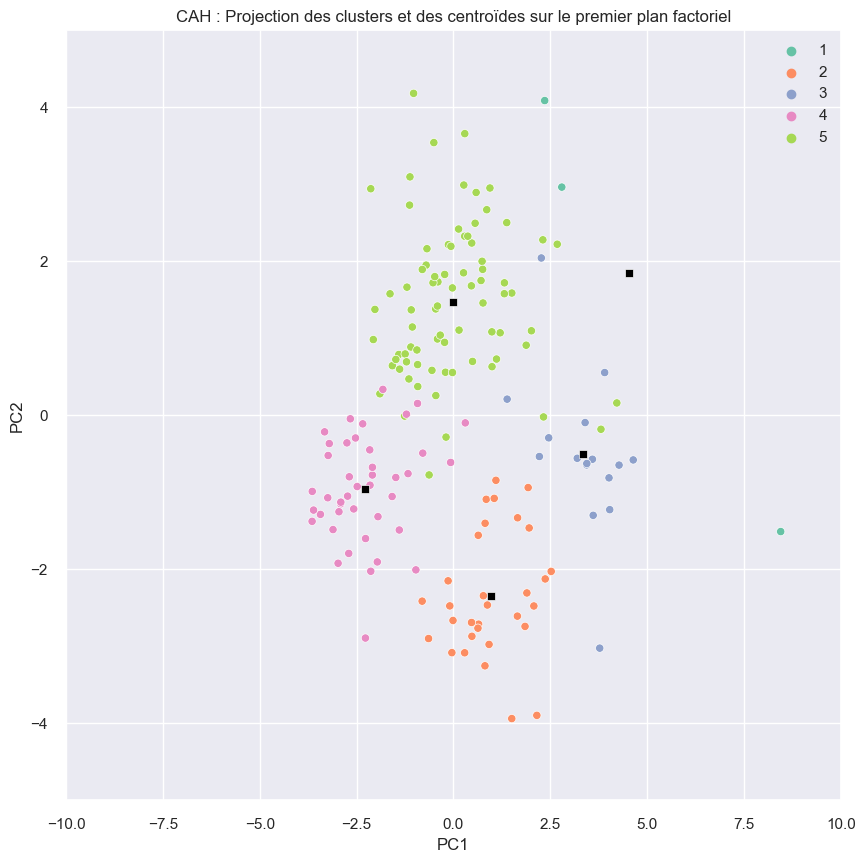

In [21]:
# Affichage des clusters et des centroïdes sur le premier plan factoriel de l'ACP
fig, ax = plt.subplots(1,1, figsize=(10,10))# Définition figure et axe

sns.scatterplot(data=None, x=X_proj[:, 0],y=X_proj[:, 1], 
                hue=clusters, palette='Set2', ax=ax)# Affichage des individus
sns.scatterplot(data=None, x=centroid_CAH_proj.iloc[:, 0], y=centroid_CAH_proj.iloc[:, 1],  
                marker="s", c="black", ax=ax)# Affichage des centroïdes

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("CAH : Projection des clusters et des centroïdes sur le premier plan factoriel")
plt.xlim(-10,10)
plt.ylim(-5,5)
plt.show()

In [22]:
# Projection sur les 3 premières composantes de l'ACP - graphique 3D
fig = px.scatter_3d(
    X_proj[:,:3], x=0, y=1, z=2, color=clusters,
    title=f'Clustering CAH - Total Explained Variance: {scree.iloc[2,3]:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

#### 2.1.3. Pays et localisation géographique des clusters<a class="anchor" id="5_2_1_3">

In [23]:
# Création d'un dataframe avec les clusters du CAH
df_CAH = df.copy()
df_CAH['cluster_CAH'] = clusters

##### Liste des pays

In [24]:
# Liste des individus de chaque cluster
for i in range(1,k+1):
    print('CAH - Cluster '+str(i)+': '+str(len(df_CAH.loc[df_CAH['cluster_CAH']==i].index))+' pays')
    print(df_CAH.loc[df_CAH['cluster_CAH']==i].index)    
    print('-'*100)

CAH - Cluster 1: 3 pays
Index(['Chine - RAS de Hong-Kong', 'Belgique', 'Pays-Bas'], dtype='object', name='zone')
----------------------------------------------------------------------------------------------------
CAH - Cluster 2: 31 pays
Index(['Lesotho', 'Namibie', 'Angola', 'Congo', 'Gabon',
       'Sao Tomé-et-Principe', 'Bénin', 'Cabo Verde', 'Gambie', 'Ghana',
       'Guinée', 'Guinée-Bissau', 'Libéria', 'Mauritanie', 'Djibouti',
       'Kirghizistan', 'Tadjikistan', 'Timor-Leste', 'Maldives', 'Arménie',
       'Géorgie', 'Iraq', 'Oman', 'Mongolie', 'Cuba', 'Haïti', 'Albanie',
       'Macédoine du Nord', 'Monténégro', 'Vanuatu', 'Kiribati'],
      dtype='object', name='zone')
----------------------------------------------------------------------------------------------------
CAH - Cluster 3: 16 pays
Index(['Suriname', 'Arabie saoudite', 'Émirats arabes unis', 'Koweït',
       'Antigua-et-Barbuda', 'Bahamas', 'Dominique', 'Grenade', 'Sainte-Lucie',
       'Saint-Kitts-et-Nevis', '

##### Répartition géographique des clusters

In [25]:
# Ajout de la colonne Cluster_CAH au df_complet_ok pour l'analyse
df_complet_ok['cluster_CAH'] = clusters

In [26]:
# Représentation géographique des clusters
fig = px.choropleth(df_complet_ok, locations="code_ISO3",
                    color="cluster_CAH", 
                    hover_name="zone", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = "CAH : Localisation géographique des clusters"
                   )
fig.show()

In [27]:
# Cluster par continent
df_complet_ok.pivot_table(index=['cluster_CAH'], columns='continent', values = 'zone', aggfunc='count')

continent    Afrique  Amériques  Asie  Europe  Océanie
cluster_CAH                                           
1                NaN        NaN   1.0     2.0      NaN
2               15.0        2.0   9.0     3.0      2.0
3                NaN        9.0   3.0     NaN      4.0
4               26.0        NaN  16.0     NaN      NaN
5                4.0       24.0  13.0    34.0      3.0

#### 2.1.4. Analyse des centroïdes<a class="anchor" id="5_2_1_3">

In [28]:
# Caractéristiques des centroïdes
centroid_CAH_df = df_CAH.iloc[:,:15].groupby('cluster_CAH').mean()
centroid_CAH_df

TAS         TDI        TDC         TCC        TEX  \
cluster_CAH                                                             
1            202.960000  236.580000 -33.620000 -146.886667  78.710000   
2             21.194839   99.914516 -78.719677   17.794516   2.410000   
3             16.556250   94.283125 -77.727500   13.703750   2.513750   
4             88.393095   13.561905  74.831667   87.901667   0.473571   
5            100.824231   24.377179  76.446538   84.022564  10.690897   

             dispo_alim_(kg/pers/an)  part_volaille_dispo_prot  \
cluster_CAH                                                      
1                          28.830000                 14.103333   
2                          11.876774                 17.301935   
3                          46.058750                 34.305000   
4                           4.782857                  9.054524   
5                          26.555641                 21.101538   

             Evol_pop_sur_5ans_(%)  stabilite_politique   PIB_hab_($)  \
cluster_CAH                                                             
1                         2.609295             0.726667  46120.084144   
2                         9.389457            -0.108065   3705.666434   
3                         5.428926             0.621250  17348.322336   
4                        10.173782            -0.886429   2187.899798   
5                         3.104832             0.259359  23036.253601   

             pop_ss_moyen_alim_saine_(%)  croissance_PIB_(%)  \
cluster_CAH                                                    
1                               0.986667            6.155631   
2                              58.081618            8.806378   
3                              17.579353            4.552947   
4                              71.897465            8.223977   
5                              14.011307            7.906626   

             emission_CO2_hab    pop_log  
cluster_CAH                               
1                 9906.660000  16.235028  
2                 3314.733548  14.873940  
3                15519.428750  13.017603  
4                 2848.295952  17.120400  
5                 7234.323333  16.224046

In [29]:
# Centrage-réduction des variables pour analyse - utilisation du modéle déjà entraîné
centroid_CAH_scaled = pd.DataFrame(scaler.fit_transform(centroid_CAH_df.values),
                                   index = np.unique(clusters),
                                   columns = features )
centroid_CAH_scaled

TAS       TDI       TDC       TCC       TEX  dispo_alim_(kg/pers/an)  \
1  1.727426  1.794413 -0.369373 -1.858473  1.986263                 0.362590   
2 -0.956803  0.077527 -1.013501  0.076214 -0.550155                -0.817452   
3 -1.025304  0.006781 -0.999331  0.028155 -0.546706                 1.561809   
4  0.035552 -1.007295  1.179570  0.899838 -0.614527                -1.311229   
5  0.219129 -0.871426  1.202635  0.854266 -0.274875                 0.204281   

   part_volaille_dispo_prot  Evol_pop_sur_5ans_(%)  stabilite_politique  \
1                 -0.593975              -1.128082             1.034946   
2                 -0.219238               1.037449            -0.395094   
3                  1.772778              -0.227513             0.854349   
4                 -1.185475               1.287957            -1.728568   
5                  0.225909              -0.969811             0.234367   

   PIB_hab_($)  pop_ss_moyen_alim_saine_(%)  croissance_PIB_(%)  \
1     1.734501                    -1.148954           -0.623187   
2    -0.927101                     0.931943            1.073726   
3    -0.070993                    -0.544213           -1.649169   
4    -1.022345                     1.435479            0.700894   
5     0.285938                    -0.674255            0.497737   

   emission_CO2_hab   pop_log  
1          0.458806  0.517559  
2         -0.953170 -0.433332  
3          1.661048 -1.730215  
4         -1.053080  1.136102  
5         -0.113603  0.509886

<Axes: >

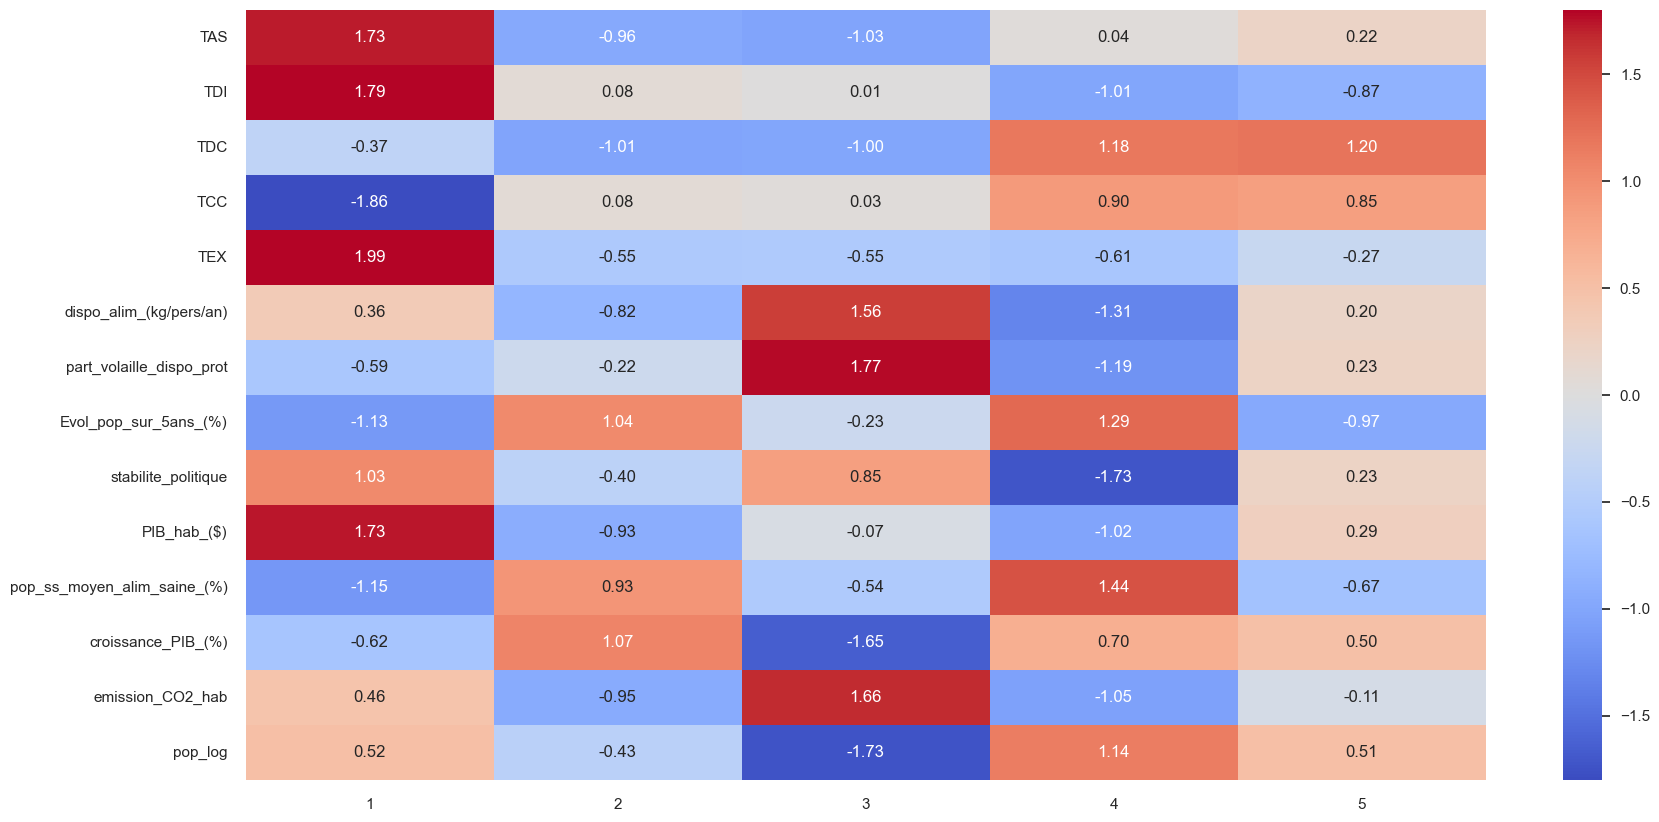

In [30]:
# Représentation sous forme de heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(centroid_CAH_scaled.T, vmin=-1.8, vmax=1.8, annot=True, cmap="coolwarm", fmt="0.2f")

C:\Users\Adeline\AppData\Local\Temp\ipykernel_26432\953053645.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



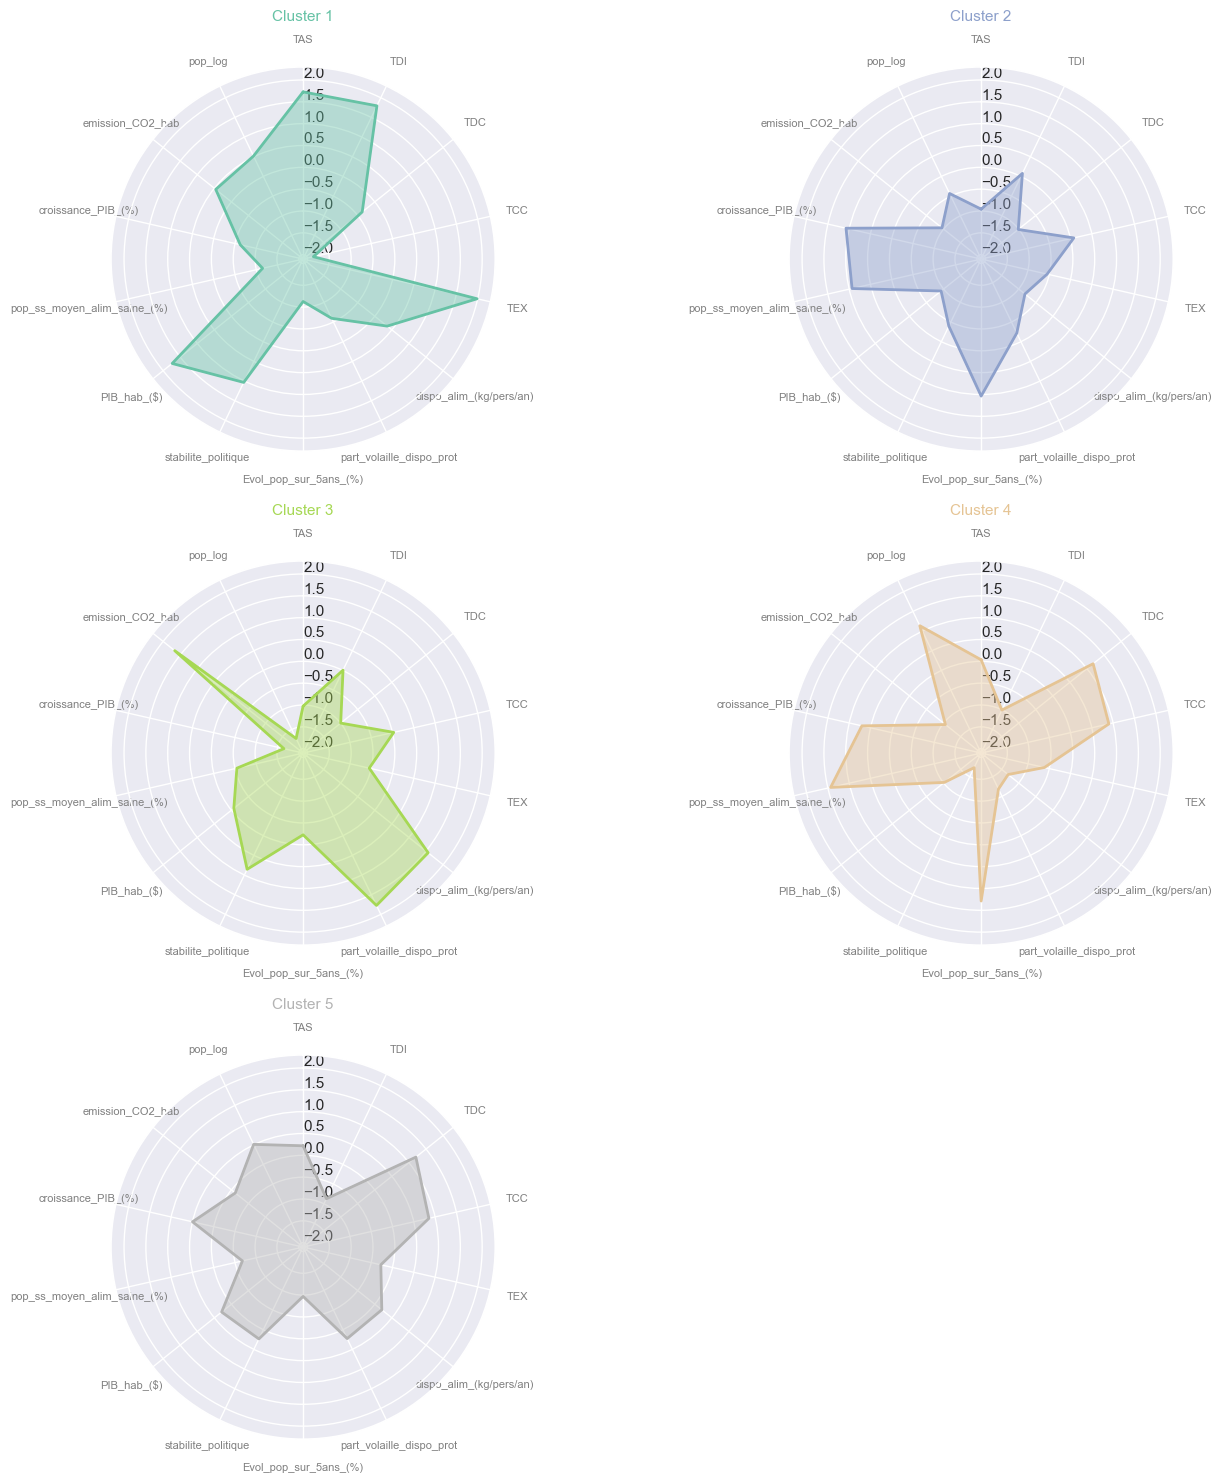

In [31]:
# Représentation des centroïdes sur des radar charts
data = centroid_CAH_scaled.reset_index()
data = data.rename(columns={'index':'cluster_CAH'})
# initialize the figure
plt.figure(figsize=(15, 15))
 
# Create a color palette:
my_palette = cm.get_cmap("Set2", len(data.index))
 
# Loop to plot
for row in range(0, len(data.index)):
    make_spider(data=data, 
                group='cluster_CAH',
                row=row, 
                title='Cluster '+str(data['cluster_CAH'][row]), 
                color=my_palette(row))

#### 2.1.5. Caractérisation des clusters CAH<a class="anchor" id="5_2_1_5">

|Cluster|Taille|Continents      |Autosuffisance|Importations    |Exportations    |Pouvoir achat|Stabilité pol.|Population|
|:----: |:----:|:---------------|:------------:|:--------------:|:--------------:|:-----------:|:------------:|:--------:|
|1      |3     |Europe et Asie  |TAS ++++      |TDI ++++ (TDC<0)|TEX ++++(TCC<0) |++++         |+++           |+++       |
|2      |31    |Afrique et Asie |TAS --        |TDI ++  (TDC<0) |TEX -   (TCC>0) |-            |-             |++        |
|3      |16    |Majorité d'îles |TAS --        |TDI ++  (TDC<0) |TEX -   (TCC>0) |+            |++            |+         |
|4      |42    |Afrique et Asie |TAS +         |TDI -   (TDC>0) |TEX -   (TCC>>0)|--           |--            |++++      |
|5      |78    |Europe-Amériques|TAS ++        |TDI --  (TDC>0) |TEX +   (TCC>>0)|++           |+             |+++       |

* Le cluster 1 peut également être une cible.
* Le cluster 2 est la meilleure cible potentielle. 
* Le cluster 3 n'est pas une cible : trop instable, indépendance aux importations, très faible revenu
* Les clusters 2 et 5 peuventt contenir quelques pays cibles mais la majorité des pays de ces clusters ne sont pas des cibles.

### 2.2. Clustering par la méthode des k-means<a class="anchor" id="5_2_2"></a></font>

#### 2.2.1. Choix du nombre de clusters<a class="anchor" id="5_2_2_1">

Différentes méthodes peuvent être utilisées pour déterminer le nombre optimal de clusters k :
* Méthode du coude sur le distorsion score : distorsion score = moyenne de la somme des carrés des écarts de distances entre les individus d'un cluster et son centroïde 

$$distortion = \frac{1}{n}\Sigma(distance(point, centroïde)^2)$$

* Méthode du coude sur l'inertie : inertie = somme des carrés des écarts de distances entre les individus d'un cluster et son centroïde

$$inertie = \Sigma(distance(point, centroïde)^2)$$

* Silhouette score / plot : 
Le coefficient de silhouette est la moyenne des différences entre la distance moyenne d'un point avec les points du même groupe que lui (cohésion) et la distance moyenne du point avec les points des autres groupes voisins (séparation). 
Plus le coefficient de silhouette est élevé, meilleure est la classification.

Résultats :
* Méthode du coude sur le distorsion score = 5 clusters
* Méthode du coude sur l'inertie : autour de 6 clusters 
* Silhouette score : 5 clusters
* Silhouette plot : optimum 5 clusters

Le nombre de clusters est fixé à 5.

*Nota : un random_state a été fixé pour permettre de réaliser les analyses sur un même modèle et de l'exécuter par la suite.*

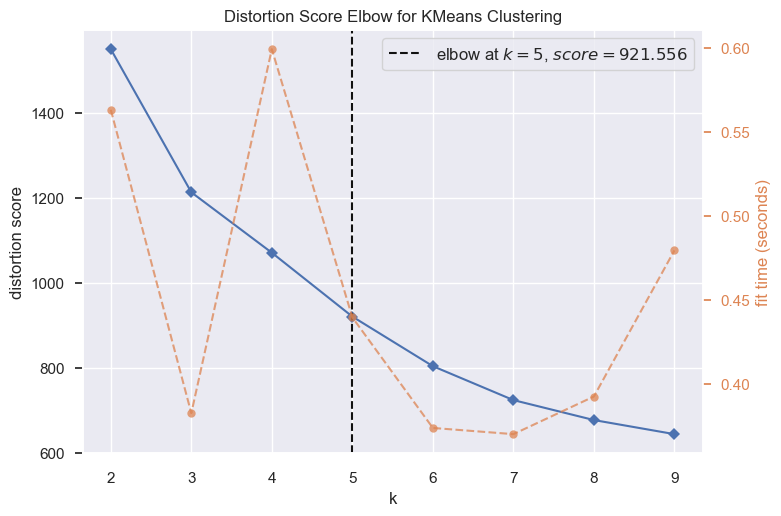

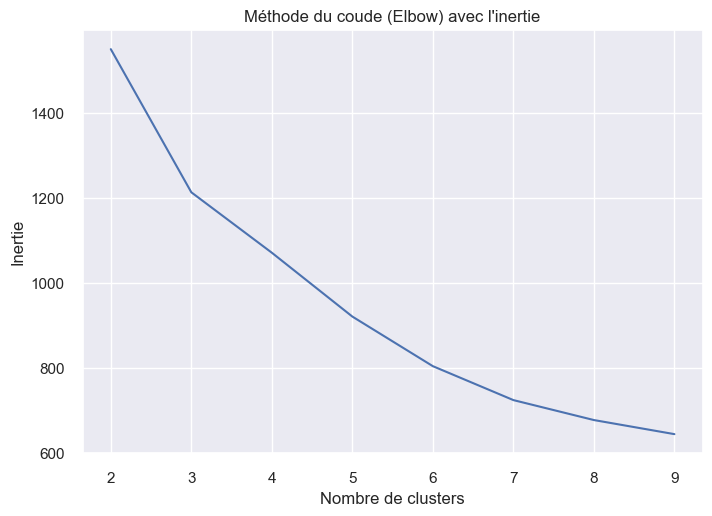

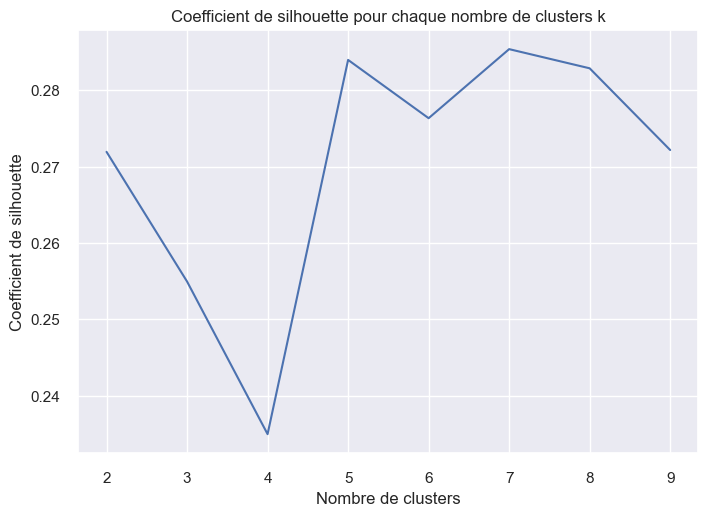

In [32]:
# Instanciation du modèle de clustering et du visualizer
km = KMeans(n_init=10, init='k-means++', random_state=24)
visualizer = KElbowVisualizer(km, k=(2,10))
# Entraînement du visualizer sur les résultats de l'ACP 
visualizer.fit(X_proj)
# Affichage du graphique
visualizer.show()
plt.show()

inertia_scores = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,n_init=10, init='k-means++',random_state=24)
    kmeans.fit(X_proj)
    labels = kmeans.labels_
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_proj, labels))

plt.plot(range(2, 10), inertia_scores)
plt.title("Méthode du coude (Elbow) avec l'inertie")
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

plt.plot(range(2, 10), silhouette_scores)
plt.title('Coefficient de silhouette pour chaque nombre de clusters k')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.show()



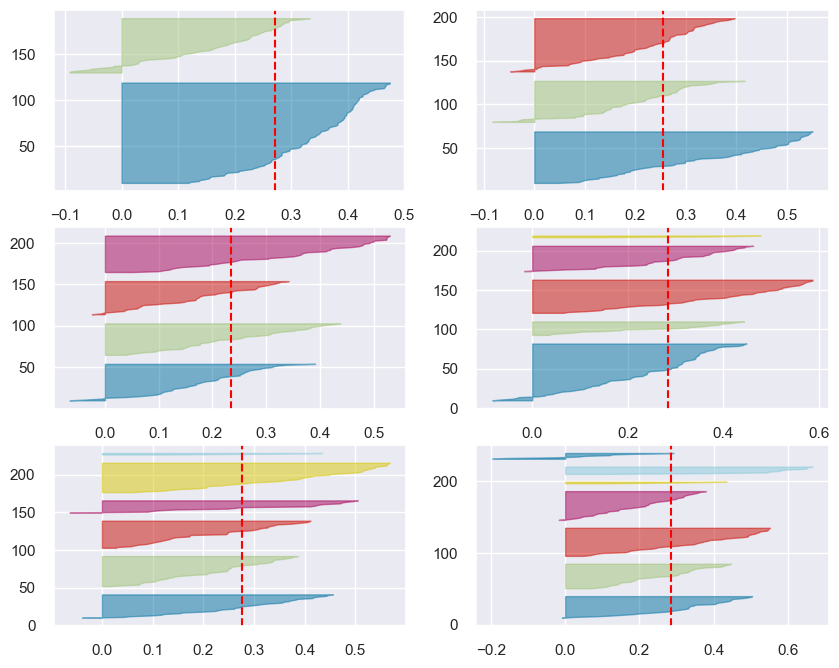

In [33]:
# Méthode du silhouette plot
fig, ax = plt.subplots(3, 2, figsize=(10,8))
for i in [2, 3, 4, 5, 6, 7]:
    # Instanciation du modèle kmeans pour différents nombres de clusters
    km = KMeans(n_clusters=i, n_init=10, init='k-means++', random_state=24)
    q, mod = divmod(i, 2)
    # Instaciation du SilhouetteVisualizer instance 
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    # entraînement du visualizer avec les résultats de l'ACP
    visualizer.fit(X_proj) 

#### 2.2.2 Clustering<a class="anchor" id="5_2_2_2">

In [34]:
# Nombre de clusters
k = 5

In [35]:
# Instaciation et Entraînement du modèle k-means
kmeans = KMeans(n_clusters=k,n_init=10, init='k-means++', random_state=24)
kmeans.fit(X_proj)

# Stockage des clusters dans la variable labels
labels = kmeans.labels_

# Stockage des centroids dans une variable
centroids = kmeans.cluster_centers_

In [36]:
# Nombre de pays par cluster
unique, counts = np.unique(labels+1, return_counts=True)

dict(zip(unique, counts))

{1: 73, 2: 18, 3: 43, 4: 33, 5: 3}

#### 2.2.3. Réprésentation graphique des clusters<a class="anchor" id="5_2_2_3">

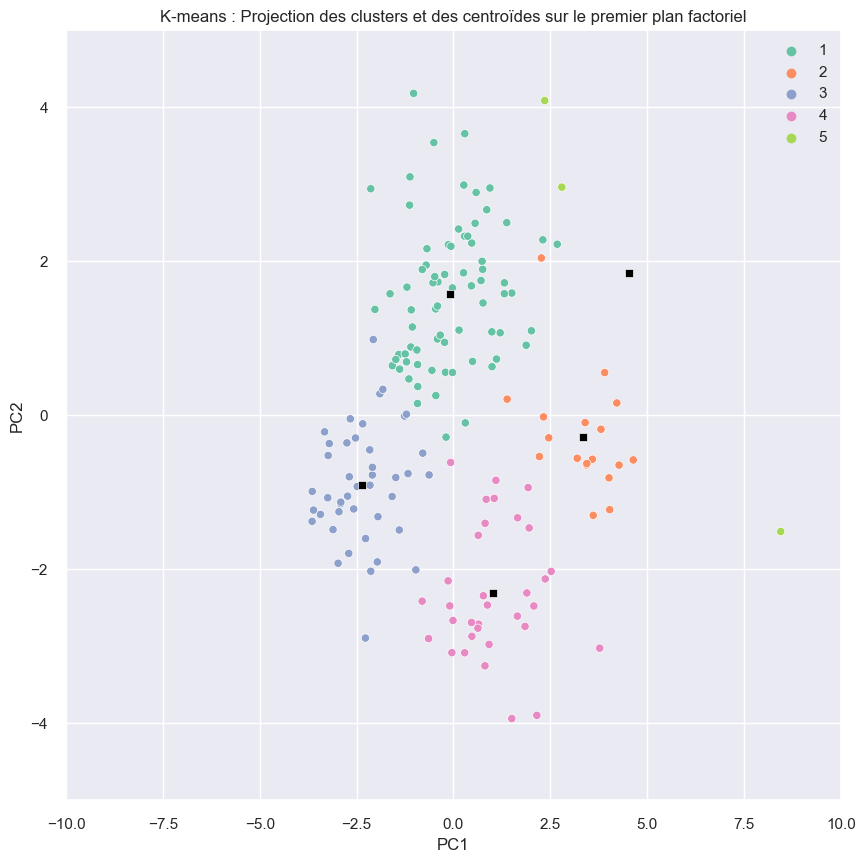

In [37]:
# Affichage des clusters sur le premier plan factoriel de l'ACP
fig, ax = plt.subplots(1,1, figsize=(10,10))# Définition figure et axe

sns.scatterplot(data=None, x=X_proj[:, 0],y=X_proj[:, 1], 
                hue=labels+1, palette='Set2', ax=ax)# Affichage des individus
sns.scatterplot(data=None, x=centroids[:, 0], y=centroids[:, 1],  marker="s", c="black", ax=ax)# Affichage des centroïdes

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("K-means : Projection des clusters et des centroïdes sur le premier plan factoriel")
plt.xlim(-10,10)
plt.ylim(-5,5)
plt.show()

In [38]:
# Projection des clusters sur les 3 premières composantes de l'ACP
fig = px.scatter_3d(
    X_proj[:,:3], x=0, y=1, z=2, color=labels,
    title=f'Clustering K-means - Total Explained Variance: {scree.iloc[2,3]:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

#### 2.2.4. Pays et localisation géographique des clusters<a class="anchor" id="5_2_2_4">

In [39]:
# Définition du  df_clusters k-means
df_kmeans = df.copy()
df_kmeans['cluster_kmeans'] = labels+1
df_kmeans.head()

TAS     TDI    TDC    TCC    TEX  dispo_alim_(kg/pers/an)  \
zone                                                                          
Afrique du Sud  78.71   24.27  54.44  75.73   2.89                    35.69   
Botswana        71.43   42.86  28.57  71.43   0.00                     3.39   
Eswatini        85.71   28.57  57.14  85.71   0.00                     6.46   
Lesotho         11.76   88.24 -76.47  11.76   0.00                     7.93   
Namibie         39.29  103.57 -64.29  -3.57  30.00                    11.53   

                part_volaille_dispo_prot  Evol_pop_sur_5ans_(%)  \
zone                                                              
Afrique du Sud                     40.83               7.326988   
Botswana                            4.50               7.506485   
Eswatini                           12.32               4.046657   
Lesotho                            22.26               3.659515   
Namibie                            18.67               8.650926   

                stabilite_politique  PIB_hab_($)  pop_ss_moyen_alim_saine_(%)  \
zone                                                                            
Afrique du Sud                -0.28  6723.928582                         65.2   
Botswana                       1.02  6705.339802                         63.8   
Eswatini                      -0.27  3822.793411                         74.8   
Lesotho                       -0.19  1061.916962                         80.2   
Namibie                        0.63  5450.334514                         54.4   

                croissance_PIB_(%)  emission_CO2_hab    pop_log  \
zone                                                              
Afrique du Sud           17.703800          10137.44  17.858733   
Botswana                  6.779399          22671.74  14.606274   
Eswatini                 15.343500           1581.85  13.933120   
Lesotho                   9.013723           1361.71  14.553408   
Namibie                  20.196593           7066.95  14.692076   

                cluster_kmeans  
zone                            
Afrique du Sud               1  
Botswana                     4  
Eswatini                     3  
Lesotho                      4  
Namibie                      4

In [40]:
# Liste des individus de chaque cluster
for i in range(1,k+1):
    print('Kmeans - Cluster '+str(i)+': '+str(len(df_kmeans.loc[df_kmeans['cluster_kmeans']==i].index))+' pays')
    print(df_kmeans.loc[df_kmeans['cluster_kmeans']==i].index)    
    print('-'*100)

Kmeans - Cluster 1: 73 pays
Index(['Afrique du Sud', 'Maurice', 'Maroc', 'Tunisie', 'Belize', 'Costa Rica',
       'El Salvador', 'Mexique', 'Nicaragua', 'Panama', 'Argentine',
       'Bolivie (État plurinational de)', 'Brésil', 'Chili', 'Colombie',
       'Équateur', 'Guyana', 'Paraguay', 'Pérou', 'Uruguay',
       'Venezuela (République bolivarienne du)', 'Canada',
       'États-Unis d'Amérique', 'Kazakhstan', 'Malaisie', 'Thaïlande',
       'Iran (République islamique d')', 'Azerbaïdjan', 'Chypre', 'Israël',
       'Jordanie', 'Turquie', 'Chine, continentale',
       'Chine, Taiwan Province de', 'Japon', 'République de Corée',
       'Australie', 'Nouvelle-Zélande', 'Barbade', 'Jamaïque',
       'République dominicaine', 'Bosnie-Herzégovine', 'Croatie', 'Espagne',
       'Grèce', 'Italie', 'Portugal', 'Serbie', 'Slovénie', 'Allemagne',
       'Autriche', 'France', 'Suisse', 'Bélarus', 'Bulgarie',
       'Fédération de Russie', 'Hongrie', 'Pologne', 'République de Moldova',
       'R

##### Répartition géographique des clusters

In [41]:
# Ajout de la colonne Cluster_kmeans au df_complet_ok pour l'analyse
df_complet_ok['cluster_kmeans'] = labels+1


In [42]:
# Représentation géographique des clusters
fig = px.choropleth(df_complet_ok, locations="code_ISO3",
                    color="cluster_kmeans", 
                    hover_name="zone", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = "K-means : Localisation géographique des clusters"
                   )
fig.show()

In [43]:
# Cluster par continent
df_complet_ok.pivot_table(index=['cluster_kmeans'], columns='continent', values = 'zone', aggfunc='count')

continent       Afrique  Amériques  Asie  Europe  Océanie
cluster_kmeans                                           
1                   4.0       22.0  13.0    31.0      3.0
2                   NaN        9.0   4.0     2.0      3.0
3                  25.0        2.0  15.0     1.0      NaN
4                  16.0        2.0   9.0     3.0      3.0
5                   NaN        NaN   1.0     2.0      NaN

#### 2.2.5. Analyses des centroîdes<a class="anchor" id="5_2_2_5">

In [44]:
# Caractéristiques des centroïdes
centroid_kmeans_df = df_kmeans.iloc[:,:15].groupby('cluster_kmeans').mean()
centroid_kmeans_df

TAS         TDI        TDC         TCC        TEX  \
cluster_kmeans                                                             
1               103.732192   22.403151  81.328630   86.283699  11.008630   
2                17.181111   88.548333 -71.367222   14.140556   2.739444   
3                90.431628   11.799767  78.631860   89.307442   0.954884   
4                22.074848  101.218485 -79.143636   18.880606   2.263939   
5               202.960000  236.580000 -33.620000 -146.886667  78.710000   

                dispo_alim_(kg/pers/an)  part_volaille_dispo_prot  \
cluster_kmeans                                                      
1                             26.403425                 20.853973   
2                             45.136667                 32.594444   
3                              6.079302                 10.512326   
4                             11.394545                 16.678182   
5                             28.830000                 14.103333   

                Evol_pop_sur_5ans_(%)  stabilite_politique   PIB_hab_($)  \
cluster_kmeans                                                             
1                            2.909926             0.269315  21673.182717   
2                            5.427159             0.763889  27366.694662   
3                            9.910338            -0.969535   1920.022478   
4                            9.428900            -0.064545   3753.472133   
5                            2.609295             0.726667  46120.084144   

                pop_ss_moyen_alim_saine_(%)  croissance_PIB_(%)  \
cluster_kmeans                                                    
1                                 11.715577            7.889965   
2                                 12.129712            5.530716   
3                                 74.199497            8.049419   
4                                 58.491667            8.676464   
5                                  0.986667            6.155631   

                emission_CO2_hab    pop_log  
cluster_kmeans                               
1                    7509.561233  16.309029  
2                   11195.326111  13.030067  
3                    2043.709767  17.203359  
4                    5981.208788  14.820044  
5                    9906.660000  16.235028

In [45]:
# Centrage-réduction des variables pour analyse - utilisation du modéle déjà entraîné
centroid_kmeans_scaled = pd.DataFrame(scaler.fit_transform(centroid_kmeans_df.values),
                                   index = np.unique(labels+1),
                                   columns = features )
centroid_kmeans_scaled

TAS       TDI       TDC       TCC       TEX  dispo_alim_(kg/pers/an)  \
1  0.243546 -0.867601  1.214456  0.861959 -0.270916                 0.205109   
2 -1.037377 -0.044329 -0.937779  0.020931 -0.546581                 1.560611   
3  0.046703 -0.999576  1.176446  0.897209 -0.606072                -1.265506   
4 -0.964952  0.113369 -1.047387  0.076189 -0.562432                -0.880905   
5  1.712081  1.798138 -0.405735 -1.856287  1.986001                 0.380691   

   part_volaille_dispo_prot  Evol_pop_sur_5ans_(%)  stabilite_politique  \
1                  0.250362              -1.011491             0.195195   
2                  1.792915              -0.202467             0.972744   
3                 -1.108403               1.238401            -1.752475   
4                 -0.298285               1.083670            -0.329687   
5                 -0.636589              -1.108113             0.914224   

   PIB_hab_($)  pop_ss_moyen_alim_saine_(%)  croissance_PIB_(%)  \
1     0.092368                    -0.678799            0.523282   
2     0.441457                    -0.664594           -1.437800   
3    -1.118765                     1.464510            0.655825   
4    -1.006350                     0.925703            1.177044   
5     1.591291                    -1.046820           -0.918351   

   emission_CO2_hab   pop_log  
1          0.056861  0.540789  
2          1.206685 -1.705156  
3         -1.648286  1.153366  
4         -0.419929 -0.479101  
5          0.804668  0.490102

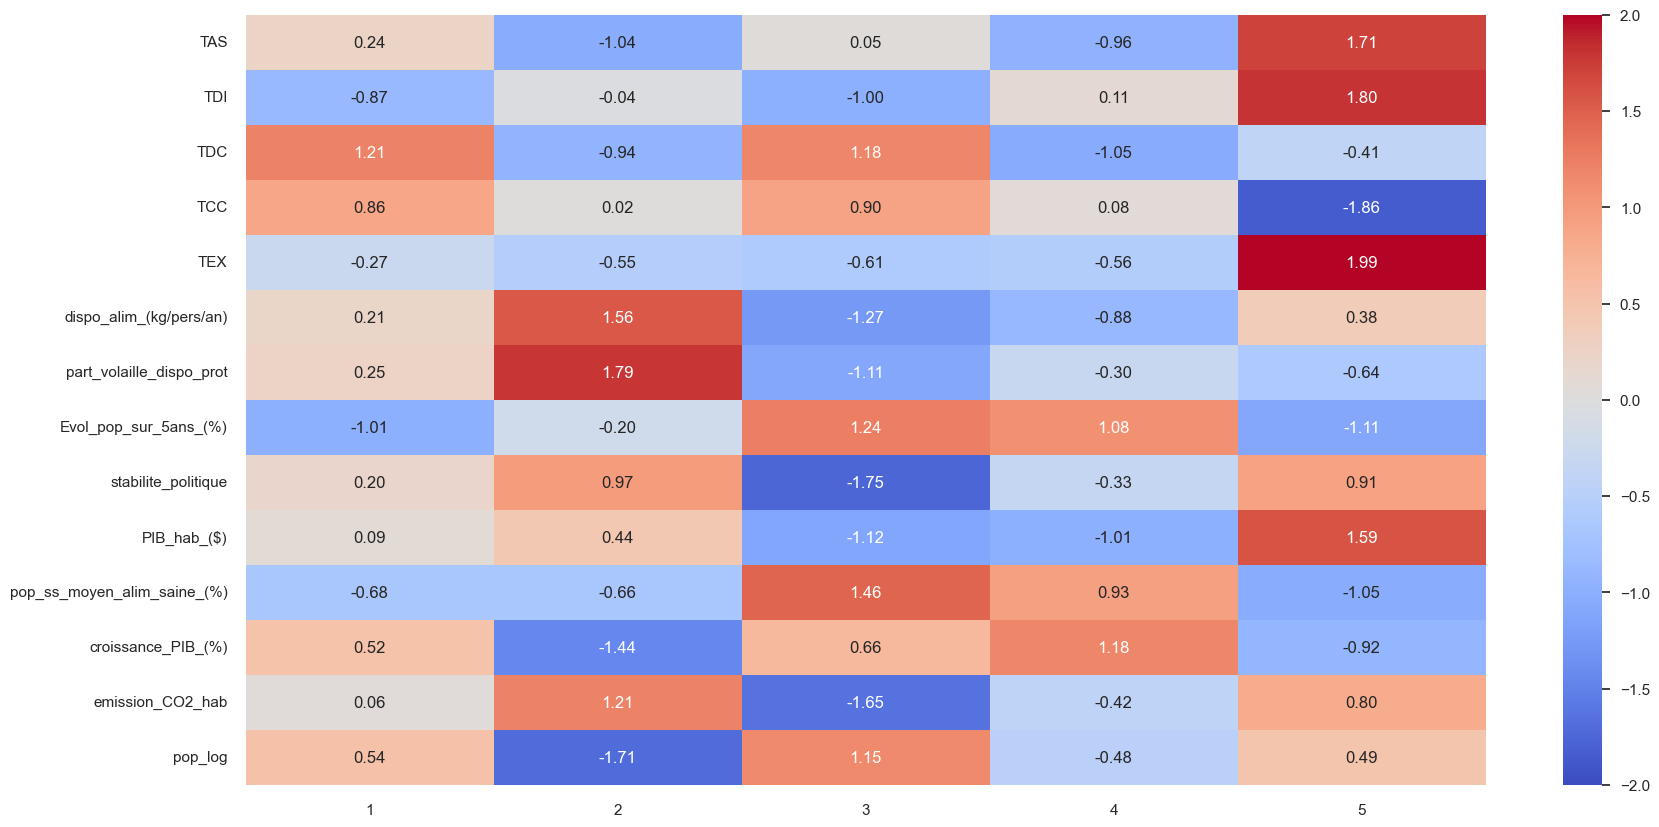

In [46]:
# Représentation sous forme de heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(centroid_kmeans_scaled.T, vmin=-2, vmax=2, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

Nous observons sur les radar charts des clusters de la méthode k-means des similarités avec les clusters obtenus avec la méthode CAH.

C:\Users\Adeline\AppData\Local\Temp\ipykernel_26432\3112815821.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



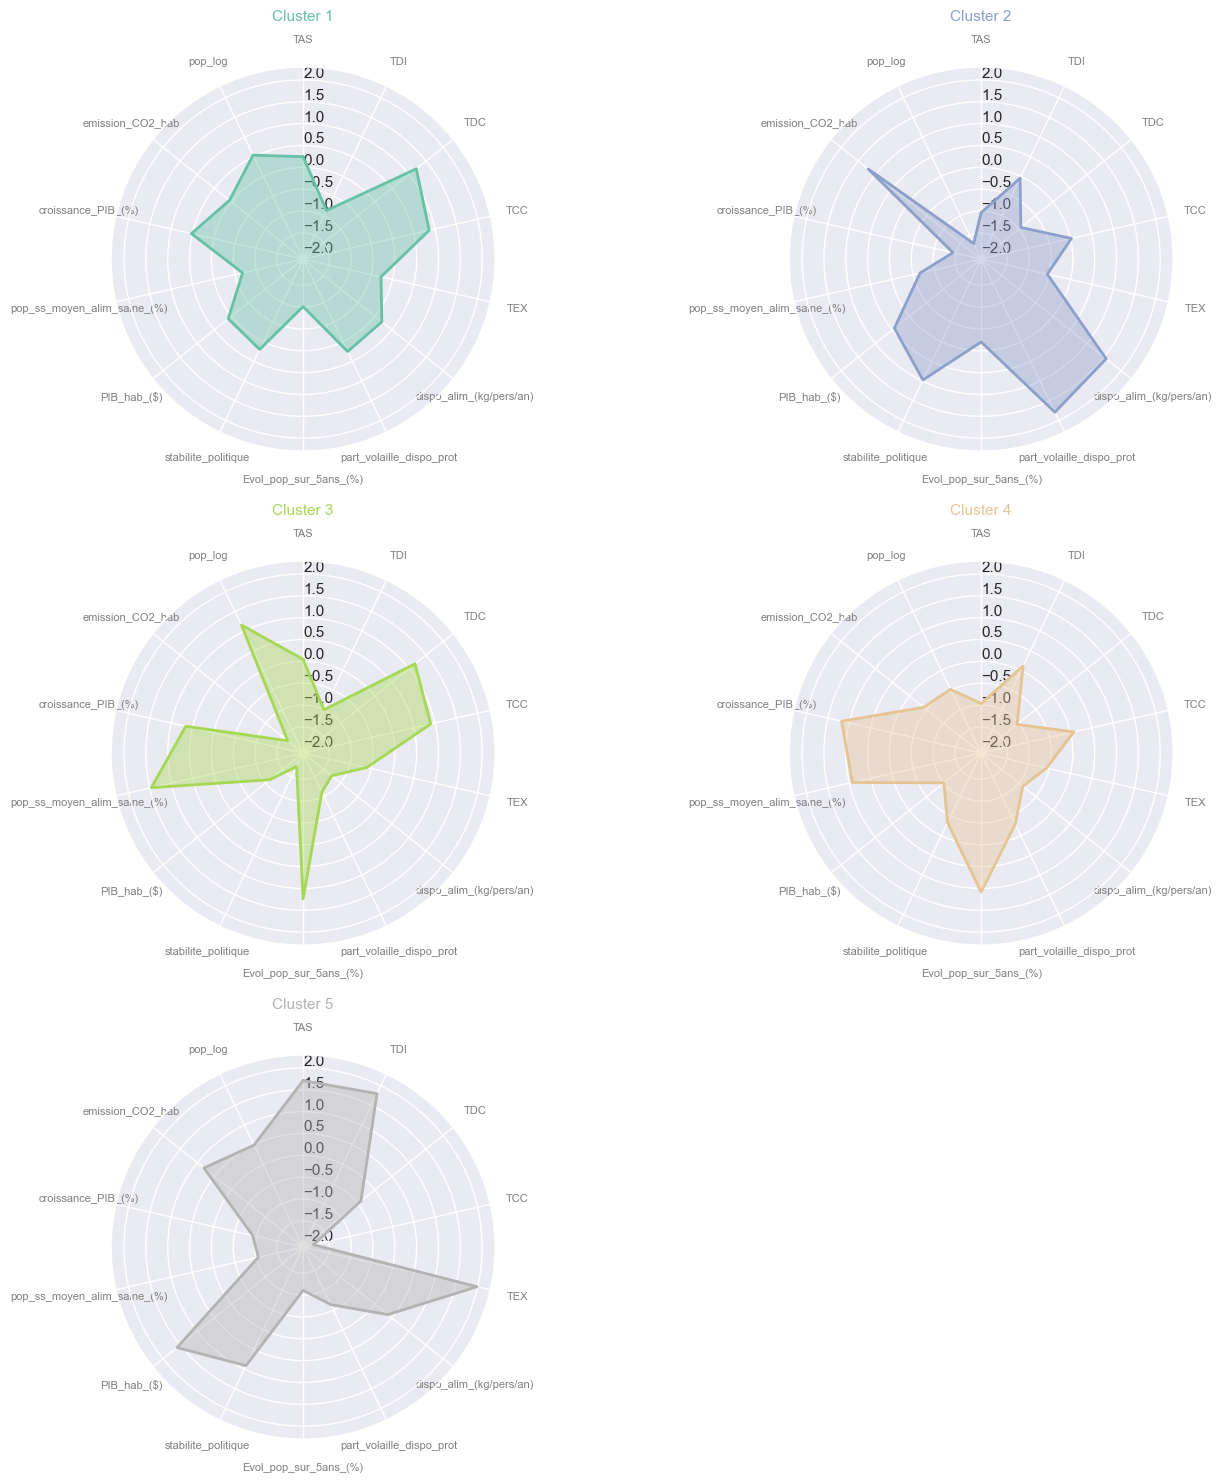

In [47]:
# Représentation des centroïdes sur des radar charts
data = centroid_kmeans_scaled.reset_index()
data = data.rename(columns={'index':'cluster_kmeans'})
# initialize the figure
plt.figure(figsize=(15, 15))
 
# Create a color palette:
my_palette = cm.get_cmap("Set2", len(data.index))
 
# Loop to plot
for row in range(0, len(data.index)):
    make_spider(data=data, 
                group='cluster_kmeans',
                row=row, 
                title='Cluster '+str(data['cluster_kmeans'][row]), 
                color=my_palette(row))

#### 2.2.6. Caractérisation des clusters  k-means<a class="anchor" id="5_2_2_6">

Nous retrouvons également des similitudes dans les radar charts de la CAH et de la méthode k-means.

La caractérisation des centroïdes est la suivante : 

|Cluster|Taille|Continents      |Autosuffisance|Importations    |Exportations    |Pouvoir achat|Stabilité pol.|Population|
|:----: |:----:|:---------------|:------------:|:--------------:|:--------------:|:-----------:|:------------:|:--------:|
|1      |73    |Europe-Amériques|TAS ++        |TDI --  (TDC>0) |TEX +   (TCC>>0)|++           |+             |+++       |
|2      |18    |Majorité d'îles |TAS --        |TDI ++  (TDC<0) |TEX -   (TCC>0) |+            |++            |+         |
|3      |43    |Afrique et Asie |TAS +         |TDI -   (TDC>0) |TEX -   (TCC>>0)|--           |--            |++++      |
|4      |33    |Afrique et Asie |TAS --        |TDI ++  (TDC<0) |TEX -   (TCC>0) |-            |-             |++        |
|5      |3     |Europe et Asie  |TAS ++++      |TDI ++++ (TDC<0)|TEX ++++(TCC<0) |++++         |+++           |+++       |

Nous retrouvons bien les mêmes clusters qu'avec la CAH :
   
* Un cluster ( cluster 1) avec des pays d'Europe et d'Amériques à revenu moyen et haut, autosuffisants qui importent peu
* Un cluster avec des pays cibles (cluster 2) : îles dépendantes des importations
* Deux clusters de pays en majorité d'Afrique et d'Asie, instables et à faible revenu en majorité (clusters 3 et 4)  où la population n'a pas les moyens de s'offrir une alimentation saine => pas des cibles
* Un cluster (cluster 5) qui contient les pays qui font de l'import / export à première vue.

Conclusion :    
* Le cluster 2 est la meilleure cible potentielle. 
* Le cluster 3 n'est pas une cible : trop instable, indépendance aux importations, très faible revenu
* Les clusters 1 et 4 peuventt contenir quelques pays cibles mais la majorité des pays de ces clusters ne sont pas des cibles.
* Le cluster 5 peut également être une cible.

### 2.3. Comparaison des résultats des 2 méthodes <a class="anchor" id="5_2_3">

##### Correspondance entre les clusters des 2 méthodes

In [48]:
# Comparaison des clusters CAH et k-means
df_complet_ok.pivot_table(index='cluster_CAH',columns='cluster_kmeans',values='zone',aggfunc='count')

cluster_kmeans     1     2     3     4    5
cluster_CAH                                
1                NaN   NaN   NaN   NaN  3.0
2                NaN   NaN   NaN  31.0  NaN
3                NaN  15.0   NaN   1.0  NaN
4                2.0   NaN  39.0   1.0  NaN
5               71.0   3.0   4.0   NaN  NaN

Les résultats des 2 méthodes sont très similaires. Les correspondances sont les suivantes :
* Cluster CAH 1 = Cluster kmeans 5
* Cluster CAH 2 = Cluster kmeans 4
* Cluster CAH 3 = Cluster kmeans 2
* Cluster CAH 4 = Cluster kmeans 3
* Cluster CAH 5 = Cluster kmeans 1

##### Comparaison des caractéristiques des centroïdes - radar charts

In [49]:
# Df avec les caractéristiques des centroïdes CAH et k-means
df_centroid_cluster_1 = centroid_kmeans_scaled.reset_index()
df_centroid_cluster_1['index'] = df_centroid_cluster_1['index'].replace([1,2,3,4,5],
                                                            ['kmeans_1','kmeans_2','kmeans_3','kmeans_4','kmeans_5'])

df_centroid_cluster_2 = centroid_CAH_scaled.reset_index()
df_centroid_cluster_2['index'] = df_centroid_cluster_2['index'].replace([1,2,3,4,5],
                                                            ['CAH_1','CAH_2','CAH_3','CAH_4','CAH_5'])

df_centroid_cluster = pd.concat([df_centroid_cluster_1,df_centroid_cluster_2],ignore_index=True)
df_centroid_cluster = df_centroid_cluster.melt(id_vars = 'index', value_vars = df_centroid_cluster.columns[1:])

df_centroid_cluster 

index variable     value
0    kmeans_1      TAS  0.243546
1    kmeans_2      TAS -1.037377
2    kmeans_3      TAS  0.046703
3    kmeans_4      TAS -0.964952
4    kmeans_5      TAS  1.712081
..        ...      ...       ...
135     CAH_1  pop_log  0.517559
136     CAH_2  pop_log -0.433332
137     CAH_3  pop_log -1.730215
138     CAH_4  pop_log  1.136102
139     CAH_5  pop_log  0.509886

[140 rows x 3 columns]

In [50]:
# df avec les données des clusters CAH et kmeans par correspondance
df_1 = df_centroid_cluster.loc[(df_centroid_cluster['index']=='CAH_1')|(df_centroid_cluster['index']=='kmeans_5')]

# Radar chart - comparaison des centroïdes 2 à 2
fig = px.line_polar(df_1, 
                    r = 'value', 
                    theta = 'variable', 
                    line_close = True,
                    color = 'index', 
                    color_discrete_map = {'CAH_1': 'dodgerblue', 'kmeans_5': 'red'},
                    title =  "Comparaison des centroïdes des clusters CAH 1 et k-means 5"
                   )
fig.update_traces(fill = 'toself')

fig.show()

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [51]:
# df avec les données des clusters CAH et kmeans par correspondance
df_2 = df_centroid_cluster.loc[(df_centroid_cluster['index']=='CAH_2')|(df_centroid_cluster['index']=='kmeans_4')]

# Radar chart - comparaison des centroïdes 2 à 2
fig = px.line_polar(df_2, 
                    r = 'value', 
                    theta = 'variable', 
                    line_close = True,
                    color = 'index',
                    color_discrete_map = {'CAH_2': 'green', 'kmeans_4': 'violet'},
                    title =  "Comparaison des centroïdes des clusters CAH 2 et k-means 4"
                   )
fig.update_traces(fill = 'toself')

fig.show()

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [52]:
# df avec les données des clusters CAH et kmeans par correspondance
df_3 = df_centroid_cluster.loc[(df_centroid_cluster['index']=='CAH_3')|(df_centroid_cluster['index']=='kmeans_2')]

# Radar chart - comparaison des centroïdes 2 à 2
fig = px.line_polar(df_3, 
                    r = 'value', 
                    theta = 'variable', 
                    line_close = True,
                    color = 'index', 
                    color_discrete_map = {'CAH_3': 'magenta', 'kmeans_2': 'goldenrod'},
                    title =  "Comparaison des centroïdes des clusters CAH 3 et k-means 2"
                   )
fig.update_traces(fill = 'toself')

fig.show()

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [53]:
# df avec les données des clusters CAH et kmeans par correspondance
df_4 = df_centroid_cluster.loc[(df_centroid_cluster['index']=='CAH_4')|(df_centroid_cluster['index']=='kmeans_3')]

# Radar chart - comparaison des centroïdes 2 à 2
fig = px.line_polar(df_4, 
                    r = 'value', 
                    theta = 'variable', 
                    line_close = True,
                    color = 'index', 
                    color_discrete_map = {'CAH_4': 'grey', 'kmeans_3': 'orange'},
                    title =  "Comparaison des centroïdes des clusters CAH 4 et k-means 3"
                   )
fig.update_traces(fill = 'toself')

fig.show()

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [54]:
# df avec les données des clusters CAH et kmeans par correspondance
df_5 = df_centroid_cluster.loc[(df_centroid_cluster['index']=='CAH_5')|(df_centroid_cluster['index']=='kmeans_1')]

# Radar chart - comparaison des centroïdes 2 à 2
fig = px.line_polar(df_5, 
                    r = 'value', 
                    theta = 'variable', 
                    line_close = True,
                    color = 'index', 
                    color_discrete_map = {'CAH_5': 'darkblue', 'kmeans_1': 'firebrick'},
                    title =  "Comparaison des centroïdes des clusters CAH 5 et k-means 1"
                   )
fig.update_traces(fill = 'toself')

fig.show()

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Adeline\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [55]:
# Remplacement du numéro de cluster CAH par la correspondance CAH-kmeans
df_complet_ok['cluster_CAH'] = df_complet_ok['cluster_CAH'].replace([1,2,3,4,5],[5,4,2,3,1])

In [56]:
# Comparaison des clusters CAH et k-means
df_complet_ok.pivot_table(index='cluster_CAH',columns='cluster_kmeans',values='zone',aggfunc='count')

cluster_kmeans     1     2     3     4    5
cluster_CAH                                
1               71.0   3.0   4.0   NaN  NaN
2                NaN  15.0   NaN   1.0  NaN
3                2.0   NaN  39.0   1.0  NaN
4                NaN   NaN   NaN  31.0  NaN
5                NaN   NaN   NaN   NaN  3.0

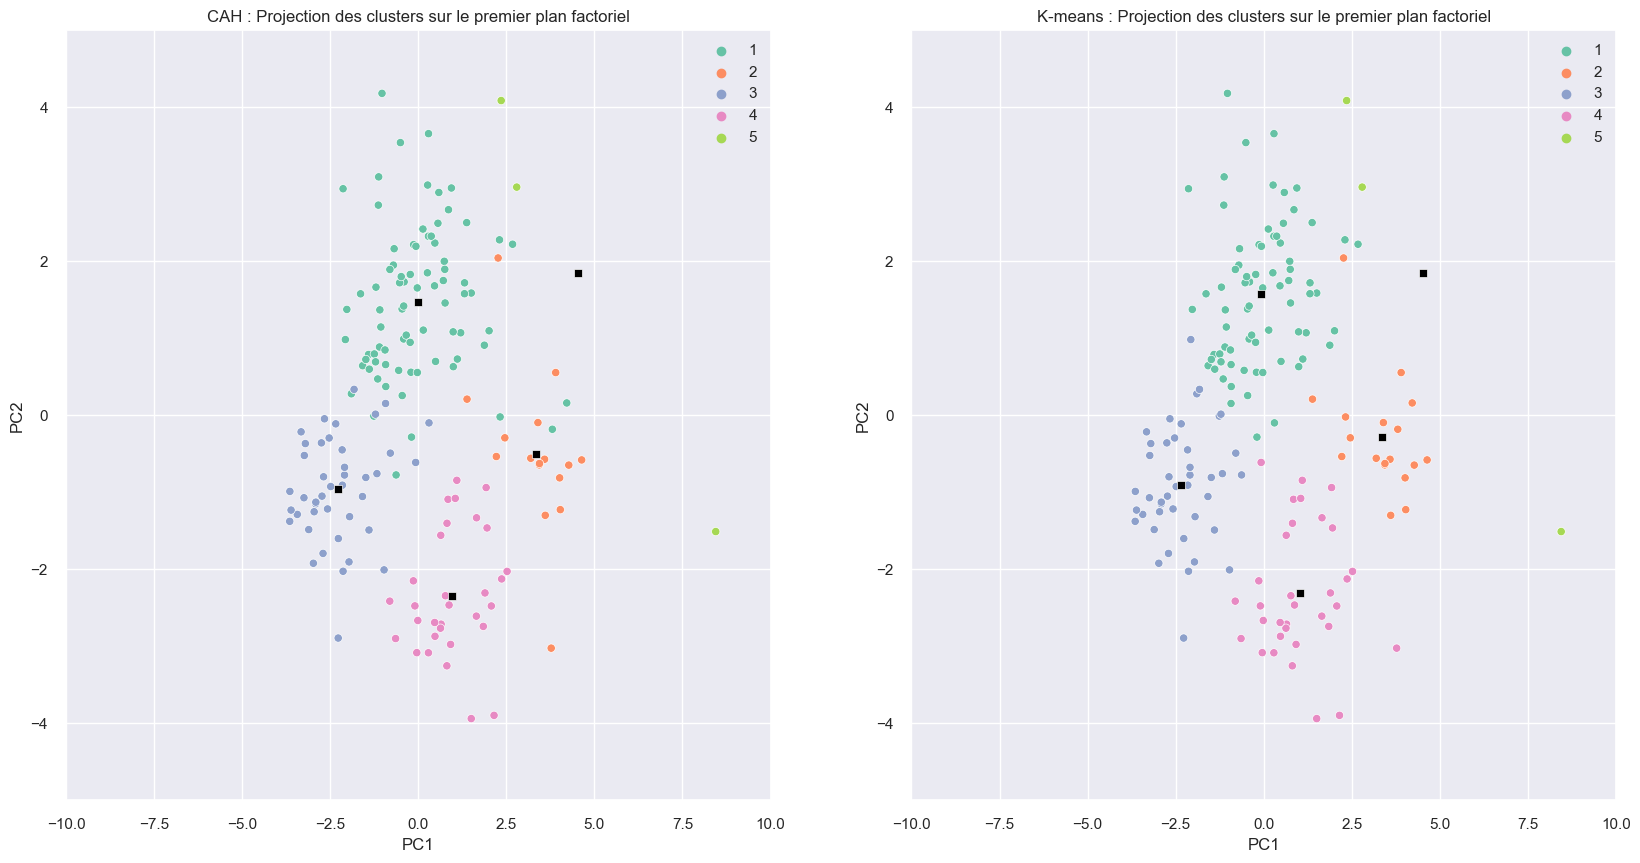

In [57]:
# Affichage des clusters et des centroïdes sur le premier plan factoriel de l'ACP
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))# Définition figure et axe

# Résultats de la méthode CAH
sns.scatterplot(data=None, x=X_proj[:, 0],y=X_proj[:, 1], 
                hue=df_complet_ok['cluster_CAH'], palette='Set2', ax=ax1)# Affichage des individus
sns.scatterplot(data=None, x=centroid_CAH_proj.iloc[:, 0], y=centroid_CAH_proj.iloc[:, 1],  
                marker="s", c="black", ax=ax1)# Affichage des centroïdes

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title("CAH : Projection des clusters sur le premier plan factoriel")
ax1.set_xlim(-10,10)
ax1.set_ylim(-5,5)

# Résultats de la méthode du k-means
sns.scatterplot(data=None, x=X_proj[:, 0],y=X_proj[:, 1], 
                hue=df_complet_ok['cluster_kmeans'], palette='Set2', ax=ax2)# Affichage des individus
sns.scatterplot(data=None, x=centroids[:, 0], y=centroids[:, 1],  
                marker="s", c="black", ax=ax2)# Affichage des centroïdes

ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_title("K-means : Projection des clusters sur le premier plan factoriel")

ax2.set_xlim(-10,10)
ax2.set_ylim(-5,5)
plt.show()

##### Différences entre les clusters des 2 méthodes

In [58]:
# Représentation géographique des clusters
fig = px.choropleth(df_complet_ok, locations="code_ISO3",
                    color="cluster_CAH", 
                    hover_name="zone", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = "CAH : Localisation géographique des clusters"
                   )
fig.show()

In [59]:
# Représentation géographique des clusters
fig = px.choropleth(df_complet_ok, locations="code_ISO3",
                    color="cluster_kmeans", 
                    hover_name="zone", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = "K-means : Localisation géographique des clusters"
                   )
fig.show()

In [60]:
# Création de df avec les listes de pays par cluster
df_kmeans_list = df_complet_ok.groupby('cluster_kmeans')['zone'].apply(list).reset_index()
df_kmeans_list.rename(columns={'cluster_kmeans': 'cluster', 'zone': 'kmeans' }, inplace=True)

df_CAH_list = df_complet_ok.groupby('cluster_CAH')['zone'].apply(list).reset_index()
df_CAH_list.rename(columns={'cluster_CAH': 'cluster', 'zone': 'CAH' }, inplace=True)

# jonction des 2 df
df_cluster = df_kmeans_list.merge(df_CAH_list, how='left', on='cluster')

# fonction comparaison des listes par ligne
def compare_lists(row):
    return list(set(row['kmeans']) - set(row['CAH']))


df_cluster['difference'] = df_cluster.apply(compare_lists, axis=1)

df_cluster

cluster                                             kmeans  \
0        1  [Afrique du Sud, Maurice, Maroc, Tunisie, Beli...   
1        2  [Suriname, Arabie saoudite, Émirats arabes uni...   
2        3  [Eswatini, Cameroun, République centrafricaine...   
3        4  [Botswana, Lesotho, Namibie, Angola, Congo, Ga...   
4        5     [Chine - RAS de Hong-Kong, Belgique, Pays-Bas]   

                                                 CAH  \
0  [Afrique du Sud, Maurice, Maroc, Tunisie, Beli...   
1  [Suriname, Arabie saoudite, Émirats arabes uni...   
2  [Botswana, Eswatini, Cameroun, République cent...   
3  [Lesotho, Namibie, Angola, Congo, Gabon, Sao T...   
4     [Chine - RAS de Hong-Kong, Belgique, Pays-Bas]   

                                  difference  
0                  [Kazakhstan, Azerbaïdjan]  
1  [Chine - RAS de Macao, Malte, Luxembourg]  
2    [Honduras, Guatemala, Myanmar, Ukraine]  
3                   [Îles Salomon, Botswana]  
4                                         []

##### Qualité des classifications
Pour comparer la qualité des résultats des 2 méthodes de classification, nous pouvons calculer le coefficient de silhouette. 

In [61]:
silhouette_score_kmeans = silhouette_score(X_proj, labels)
print("Indice de silhouette pour la méthode du k-means : ", round(silhouette_score_kmeans,2))

silhouette_score_CAH = silhouette_score(X_proj, clusters)
print("Indice de silhouette pour la méthode du dendrogramme : ", round(silhouette_score_CAH,2))

Indice de silhouette pour la méthode du k-means :  0.28
Indice de silhouette pour la méthode du dendrogramme :  0.27


La méthode des k-means a un silhouette score supérieur à la CAH : l'analyse détaillée des clusters sera réalisée sur les résultats du clustering k-means.

## <font color='green'>3. Analyse détaillée des clusters<a class="anchor" id="5_3"></a></font>

#### Pays où exporter les poulets "La Poule qui chante"
Les pays cibles doivent :
- être dépendant des importations de volaille (TAS <100%, TDI élevée, TDC <0)
- être stable politiquement
- avoir un PIB par habitant élevé et une faible part de la population n'ayant pas les moyens d'acheter une alimentation saine = bon pouvoir d'achat

### 3.1. Localisation géographique<a class="anchor" id="5_3_1">

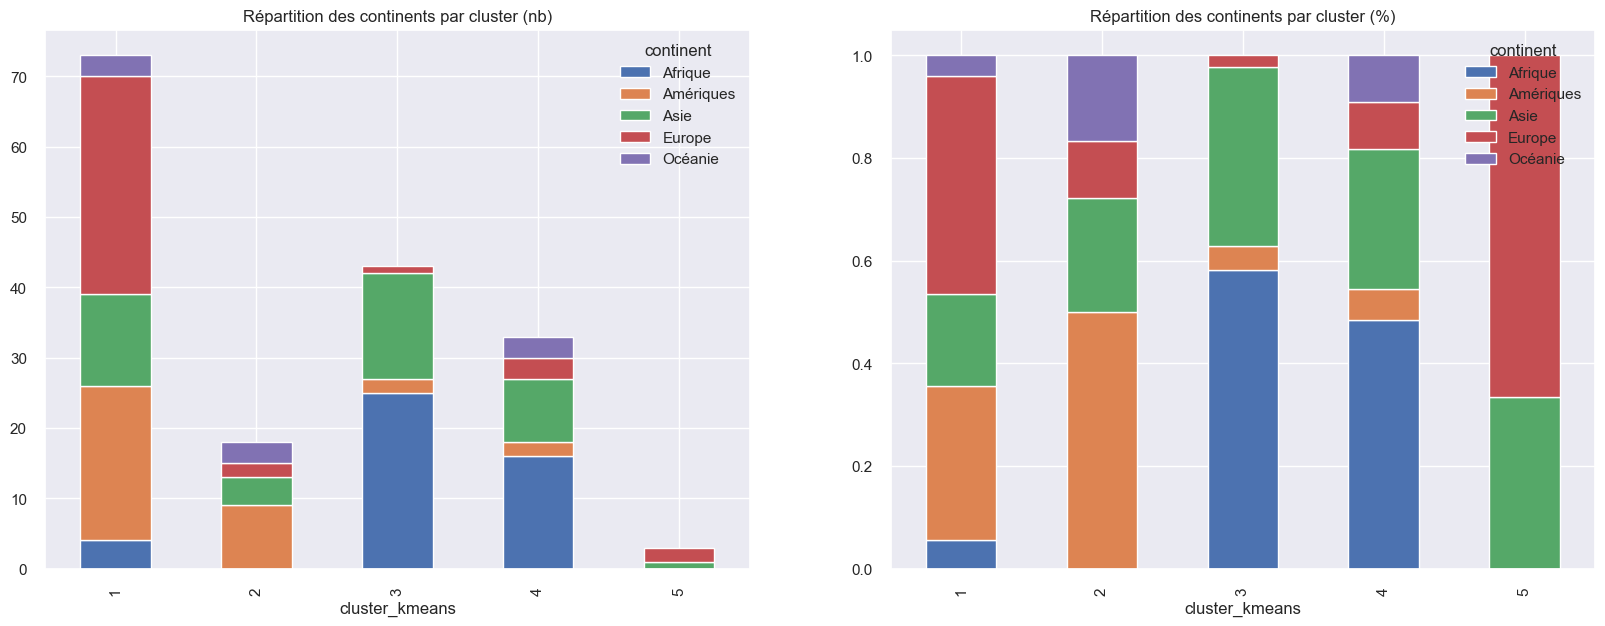

In [62]:
# Répartition des continents par cluster
fig, ax = plt.subplots(1, 2,figsize=(20,7))

# en nombre
df_complet_ok.pivot_table(index=['cluster_kmeans'], columns='continent', values = 'zone', aggfunc='count')\
            .plot(ax=ax[0], kind='bar', title="Répartition des continents par cluster (nb)", stacked=True)
# en %
df_complet_ok.groupby('cluster_kmeans')['continent']\
    .value_counts(normalize=True)\
    .unstack(level=1)\
    .plot(ax=ax[1], kind='bar', title="Répartition des continents par cluster (%)", stacked=True)
plt.show()

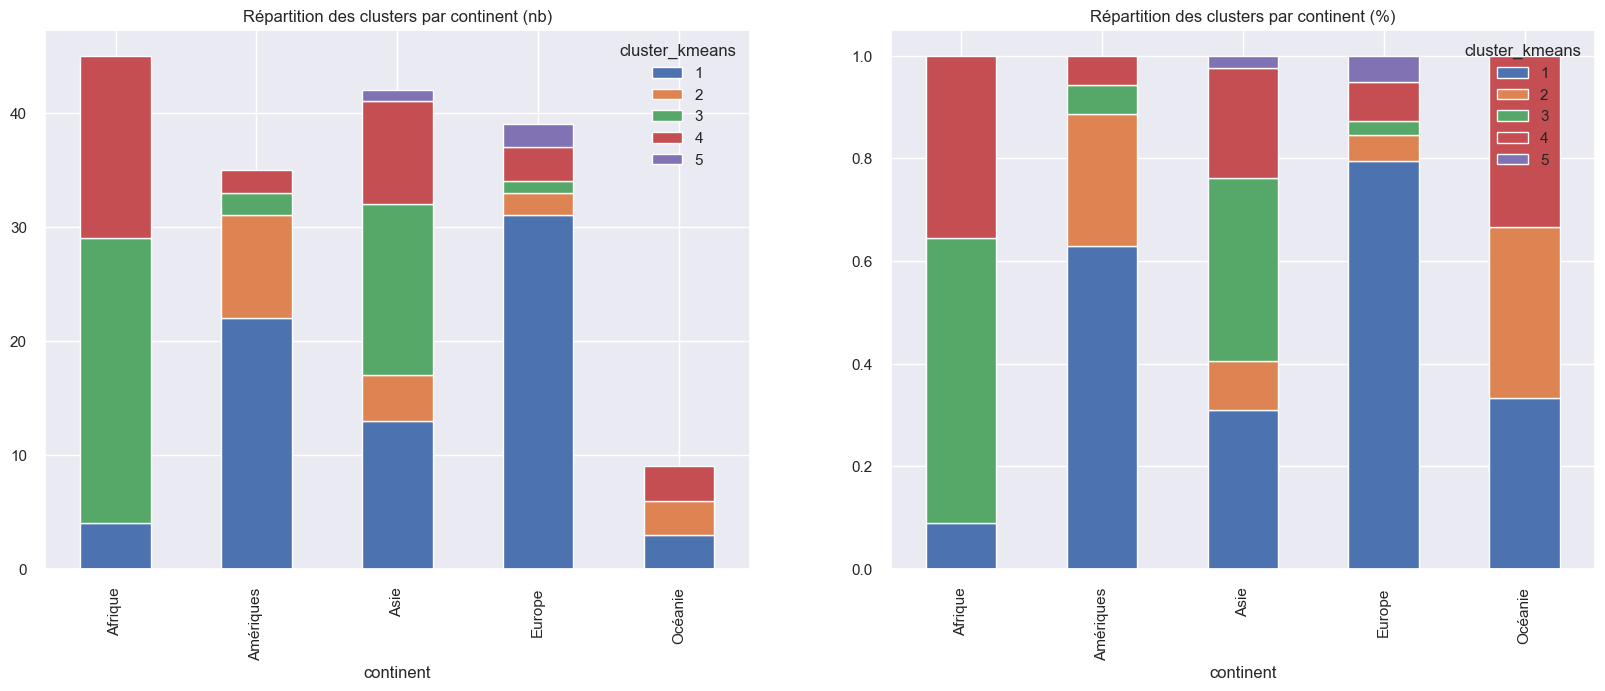

In [63]:
# Répartition des clusters par continent
fig, ax = plt.subplots(1, 2,figsize=(20,7))

# en nombre
df_complet_ok.pivot_table(index=['continent'], columns='cluster_kmeans', values = 'zone', aggfunc='count')\
            .plot(ax=ax[0], kind='bar', title="Répartition des clusters par continent (nb)", stacked=True)
# en %
df_complet_ok.groupby('continent')['cluster_kmeans']\
    .value_counts(normalize=True)\
    .unstack(level=1)\
    .plot(ax=ax[1], kind='bar', title="Répartition des clusters par continent (%)", stacked=True)
plt.show()

### 3.2. Catégorie de revenu<a class="anchor" id="5_3_2">

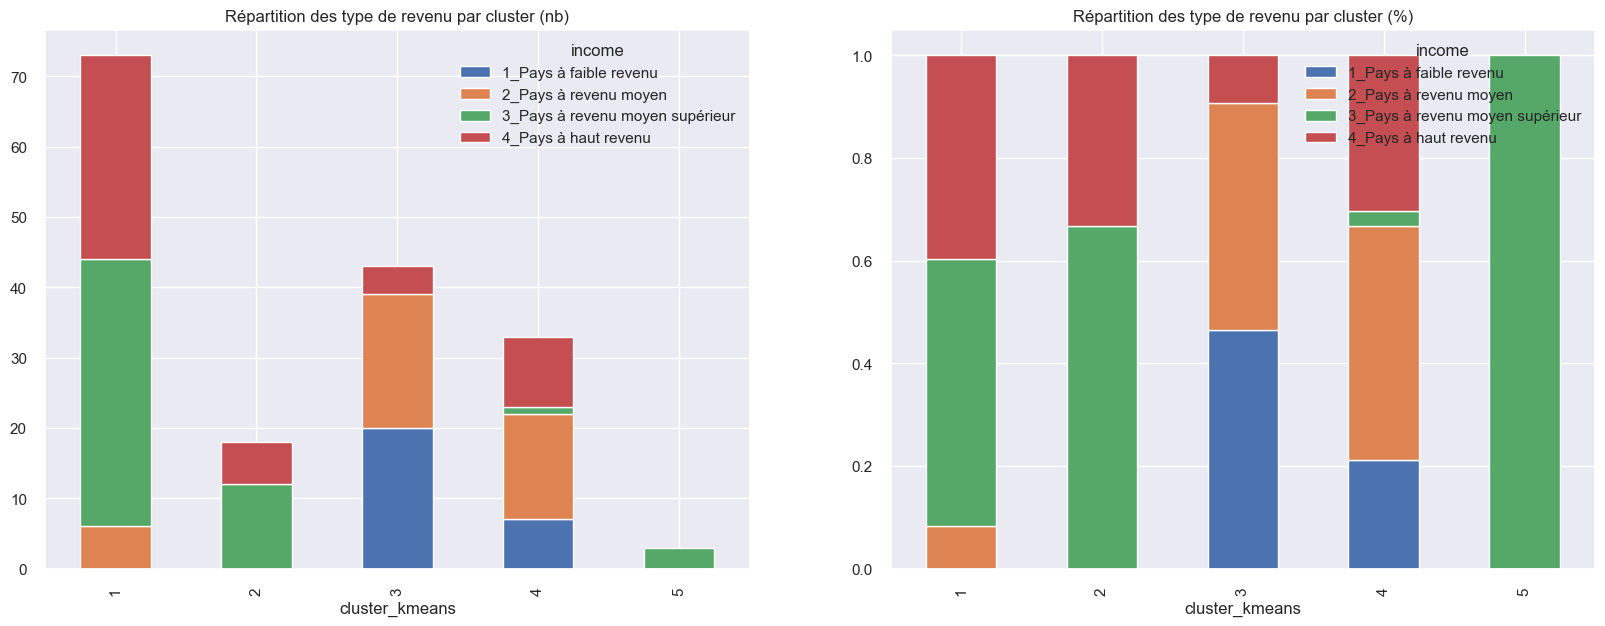

In [64]:
# Répartition des type de revenu par cluster
fig, ax = plt.subplots(1, 2,figsize=(20,7))

# en nombre
df_complet_ok.pivot_table(index=['cluster_kmeans'], columns='income', values = 'zone', aggfunc='count')\
            .plot(ax=ax[0], kind='bar', title="Répartition des type de revenu par cluster (nb)", stacked=True)
# en %
df_complet_ok.groupby('cluster_kmeans')['income']\
    .value_counts(normalize=True)\
    .unstack(level=1)\
    .plot(ax=ax[1], kind='bar', title="Répartition des type de revenu par cluster (%)", stacked=True)
plt.show()

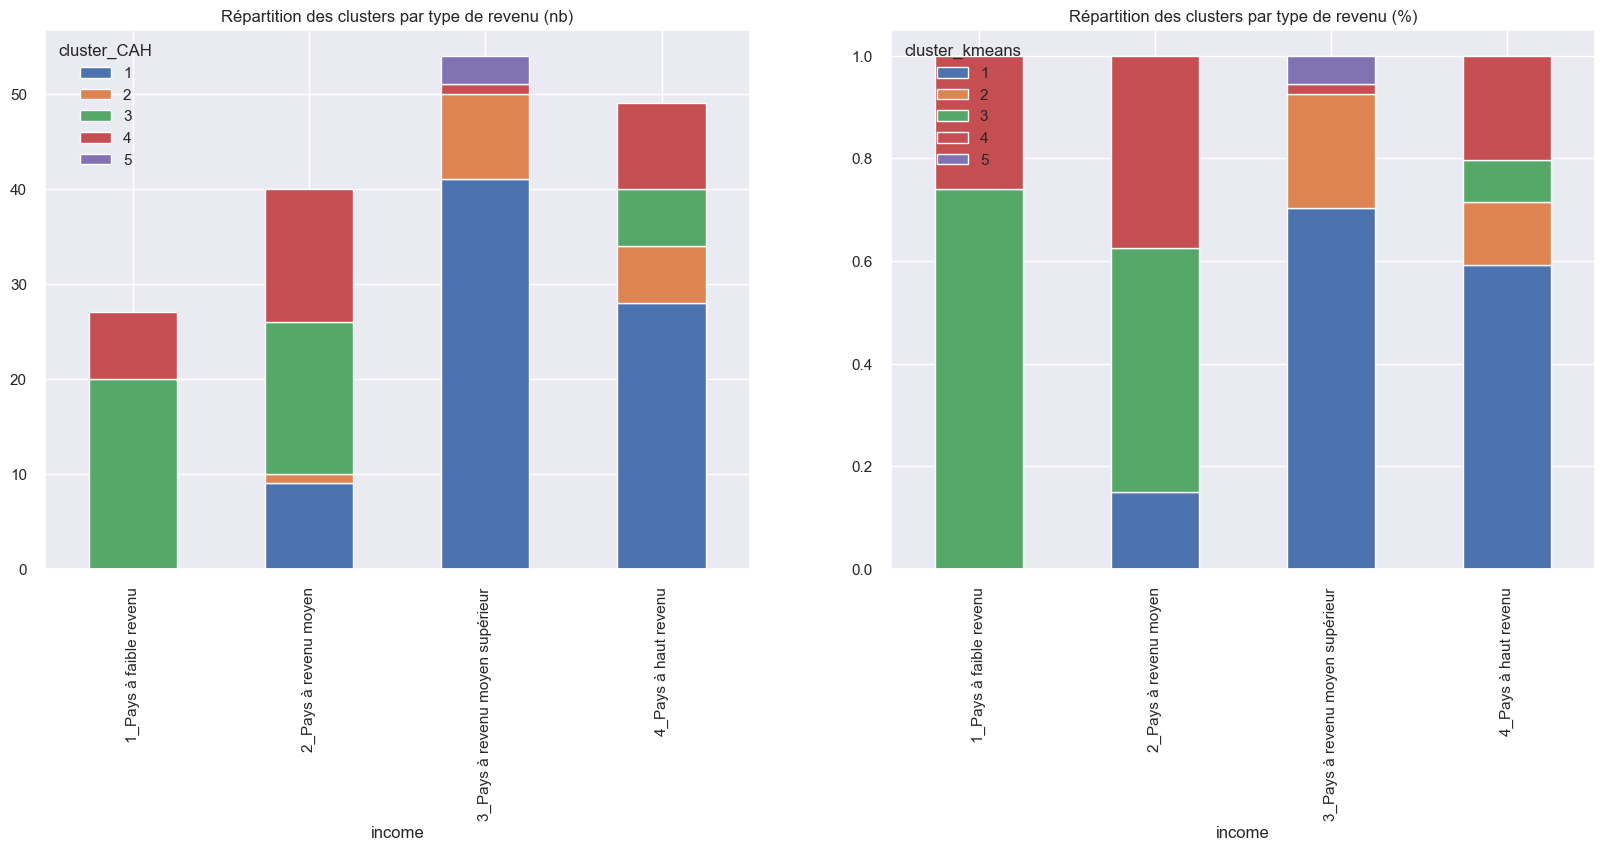

In [65]:
# Répartition des clusters par type de revenu
fig, ax = plt.subplots(1, 2,figsize=(20,7))

# en nombre
df_complet_ok.pivot_table(index=['income'], columns='cluster_CAH', values = 'zone', aggfunc='count')\
            .plot(ax=ax[0], kind='bar', title="Répartition des clusters par type de revenu (nb)", stacked=True)
# en %
df_complet_ok.groupby('income')['cluster_kmeans']\
    .value_counts(normalize=True)\
    .unstack(level=1)\
    .plot(ax=ax[1], kind='bar', title="Répartition des clusters par type de revenu (%)", stacked=True)
plt.show()

###  3.3. Population totale des clusters<a class="anchor" id="5_3_3">

In [66]:
population_millions = round(df_complet_ok.groupby('cluster_kmeans')['pop_2017'].sum()/1e6,1)
population_percent = round(df_complet_ok.groupby('cluster_kmeans')['pop_2017'].sum()/sum(df_complet_ok['pop_2017'])*100,1)

pop_cluster_df = pd.DataFrame(
    {
      "population_(millions)" : population_millions, 
       "repartition_pop_mondiale_(%)" : population_percent 
    }
)
pop_cluster_df

population_(millions)  repartition_pop_mondiale_(%)
cluster_kmeans                                                     
1                              3674.9                          50.1
2                                52.0                           0.7
3                              3358.4                          45.8
4                               208.8                           2.8
5                                35.7                           0.5

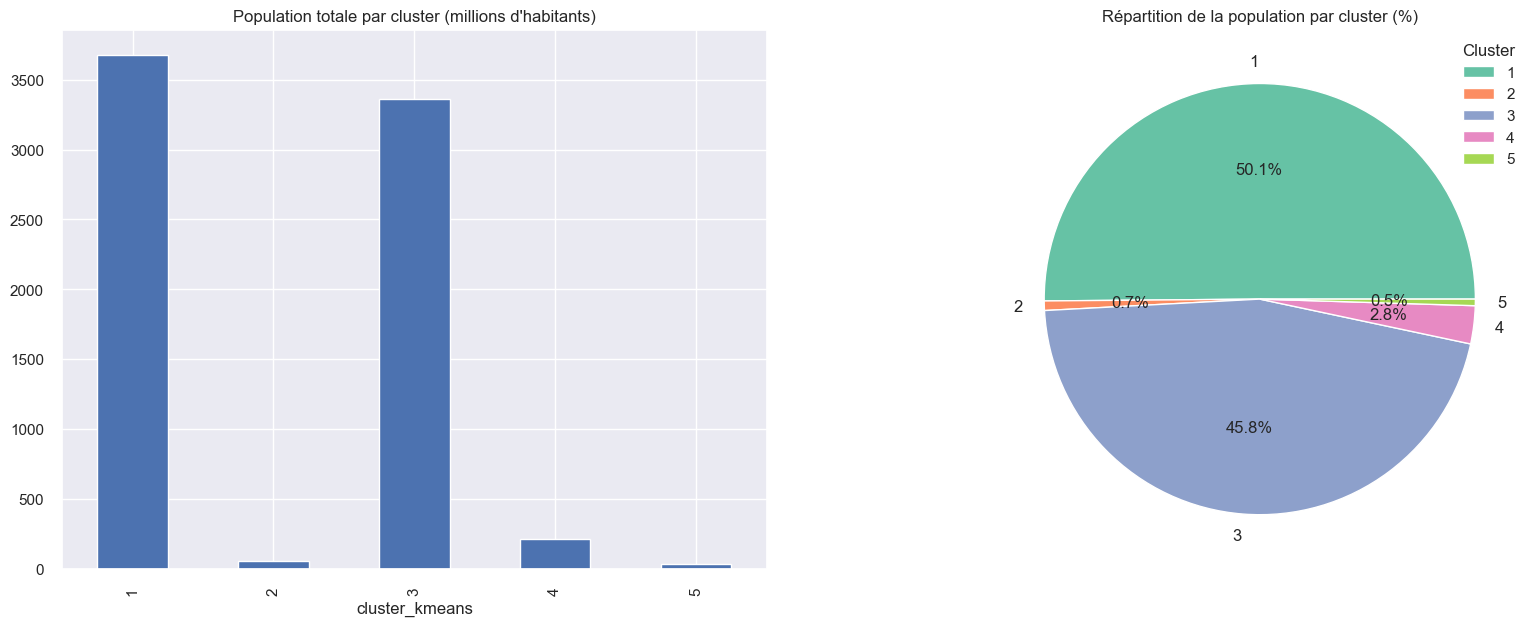

In [67]:
# Population totale des clusters
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))

# en nombre
pop_cluster_df['population_(millions)'].plot(
                                             ax=ax1, 
                                             kind='bar', 
                                             title="Population totale par cluster (millions d'habitants)", 
                                             stacked=True
                                            )
# en %
ax2.pie(x=pop_cluster_df['population_(millions)'],                                   
        colors = sns.color_palette("Set2"),
        labels = pop_cluster_df.index,
        autopct='%.1f%%',
        textprops={'fontsize': 12})
ax2.set_title("Répartition de la population par cluster (%)")                                              
ax2.legend(title='Cluster',
           fontsize=11,
           loc="upper right")                                              
plt.show()

### 3.4. Analyse par variable<a class="anchor" id="5_3_4">

------------------------------------------------------------------------------------------------------------------------
Variable TAS


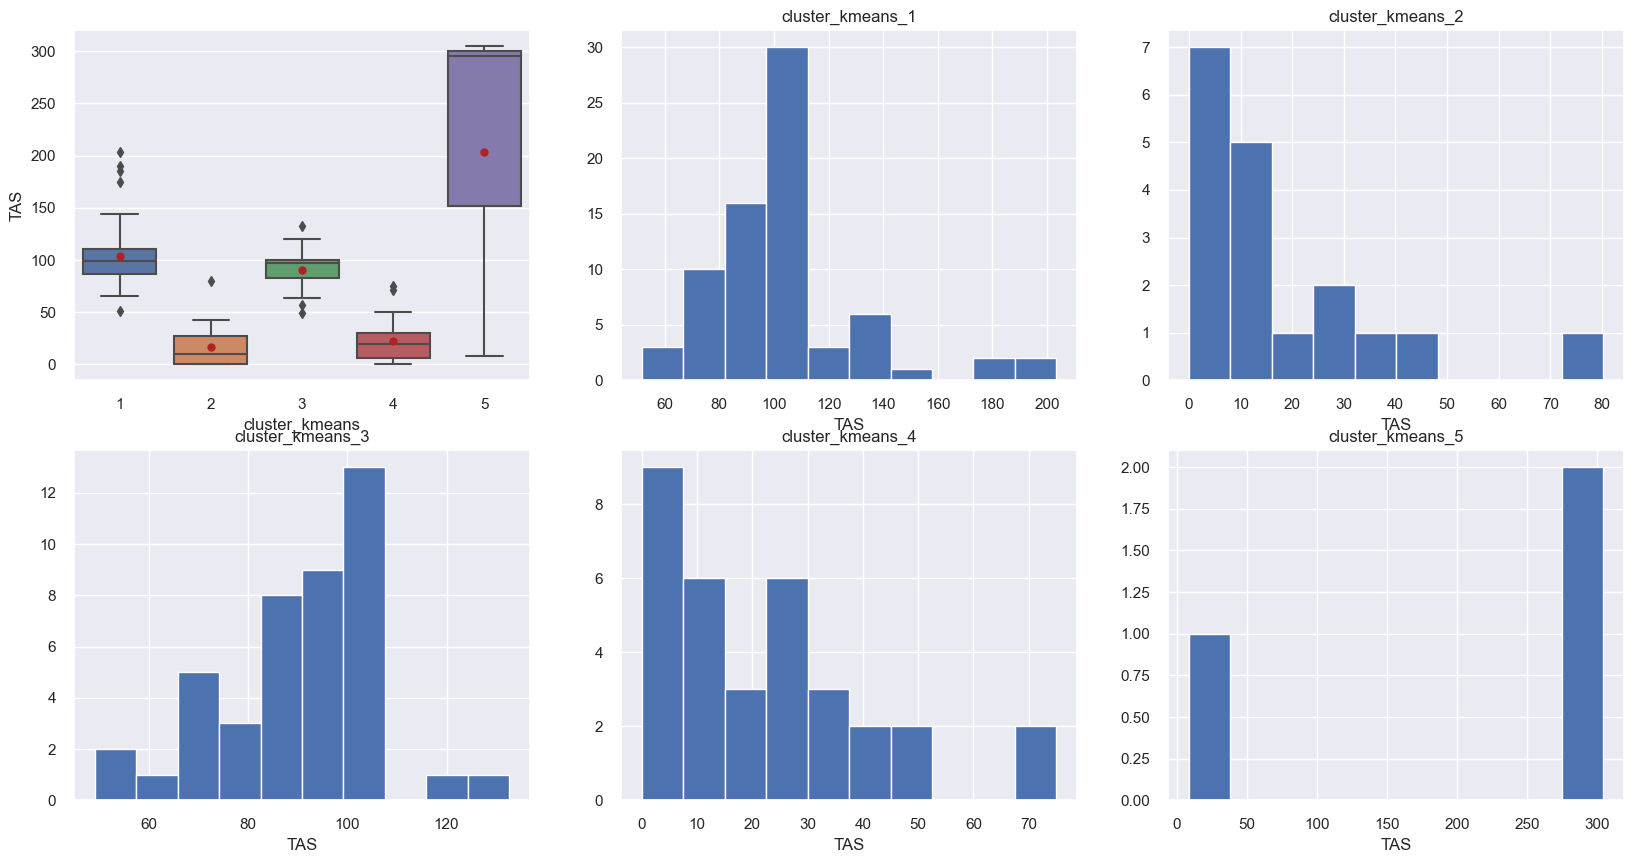

------------------------------------------------------------------------------------------------------------------------
Variable TDI


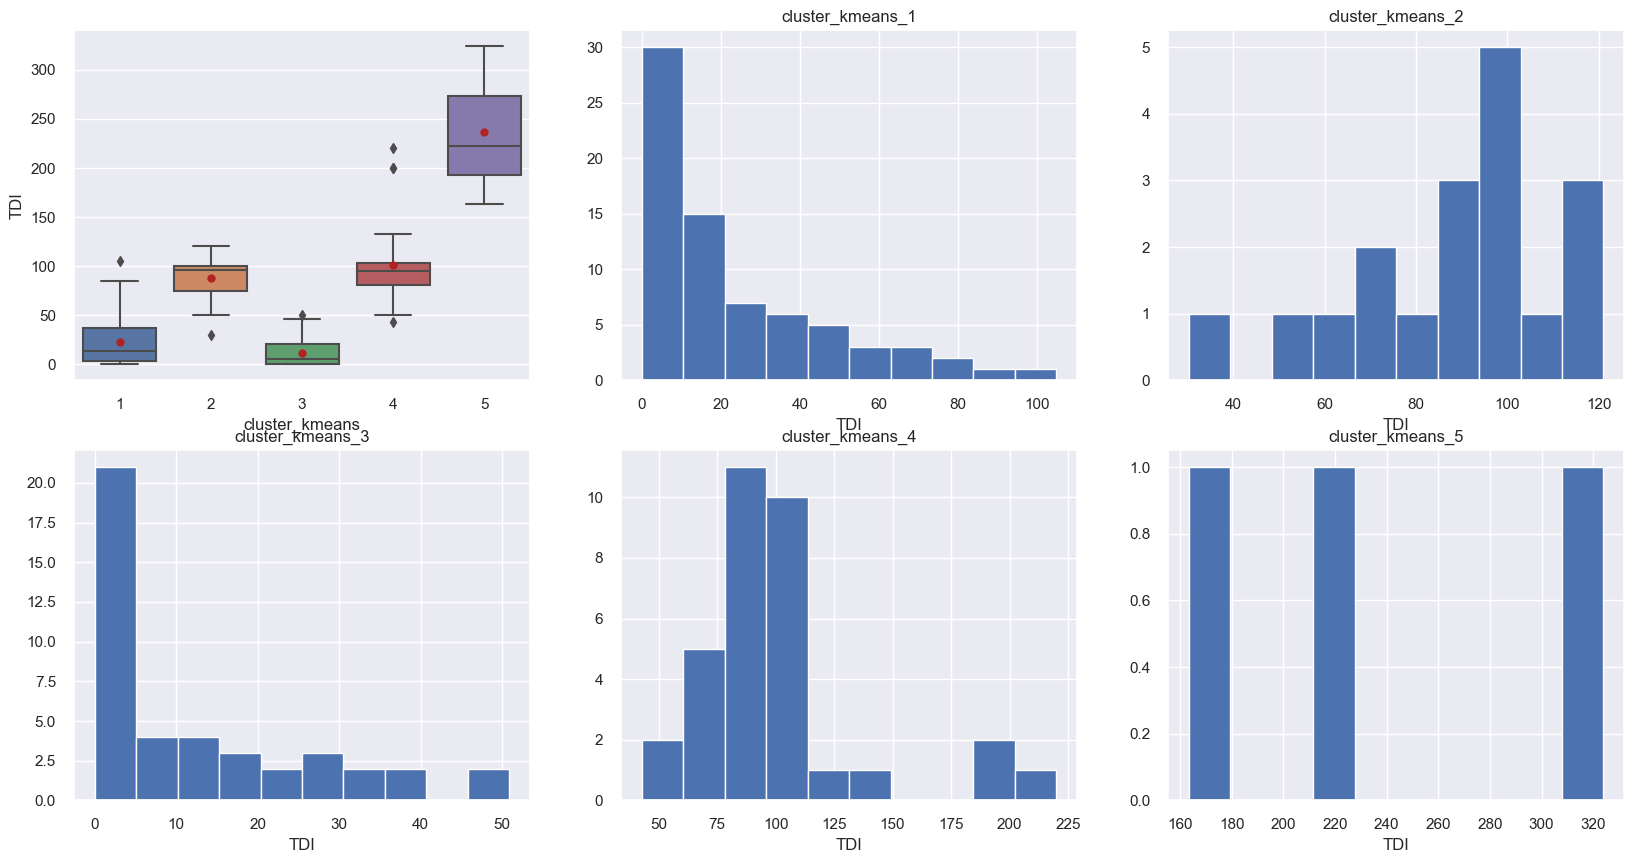

------------------------------------------------------------------------------------------------------------------------
Variable TDC


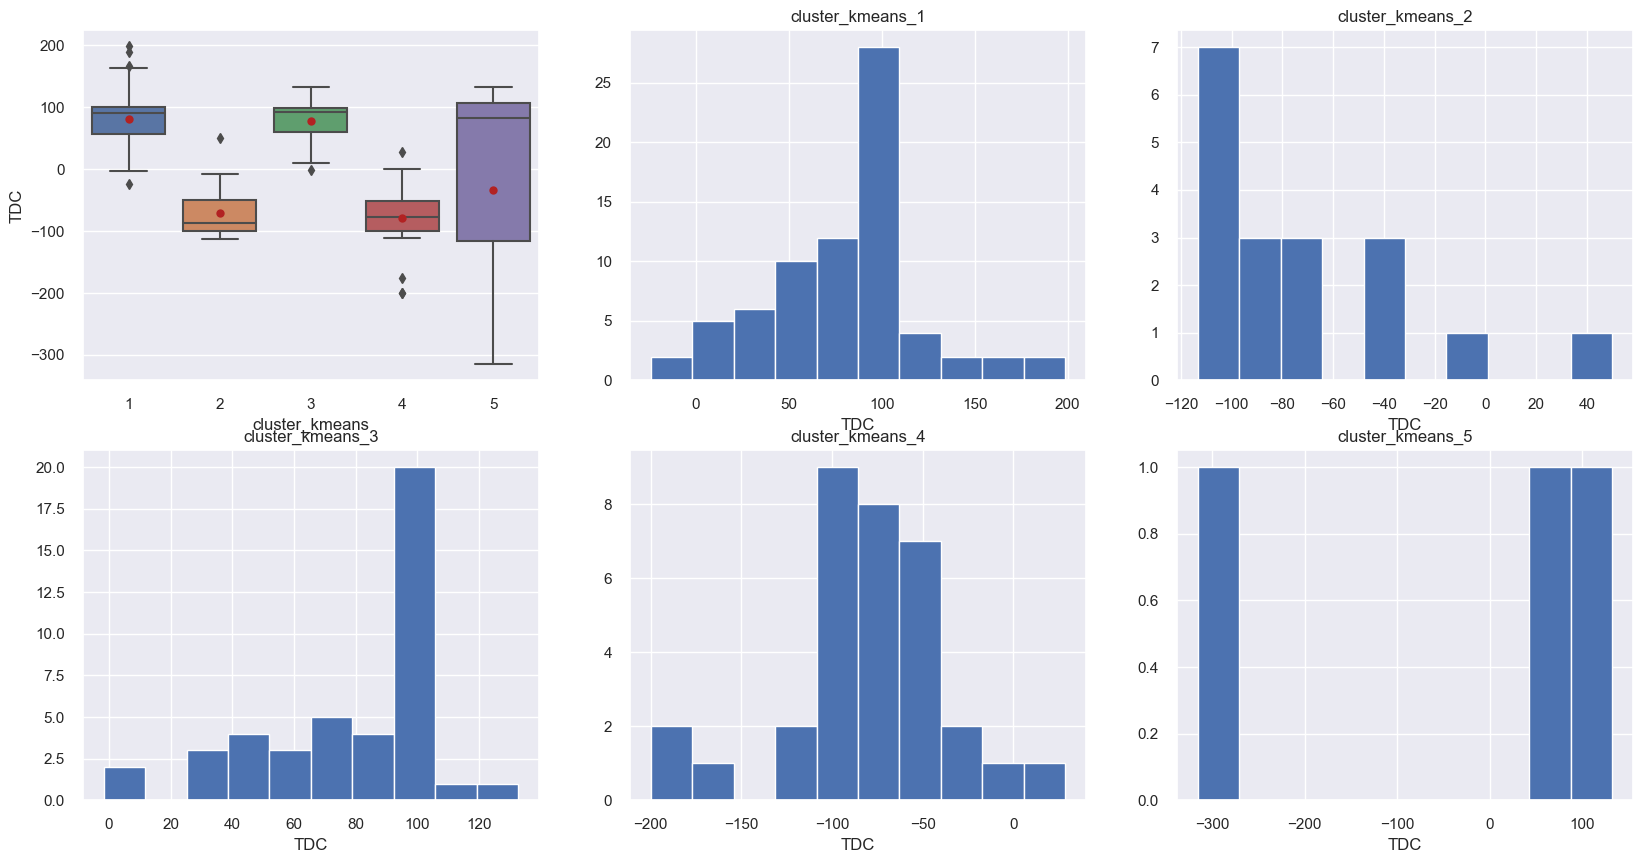

------------------------------------------------------------------------------------------------------------------------
Variable TCC


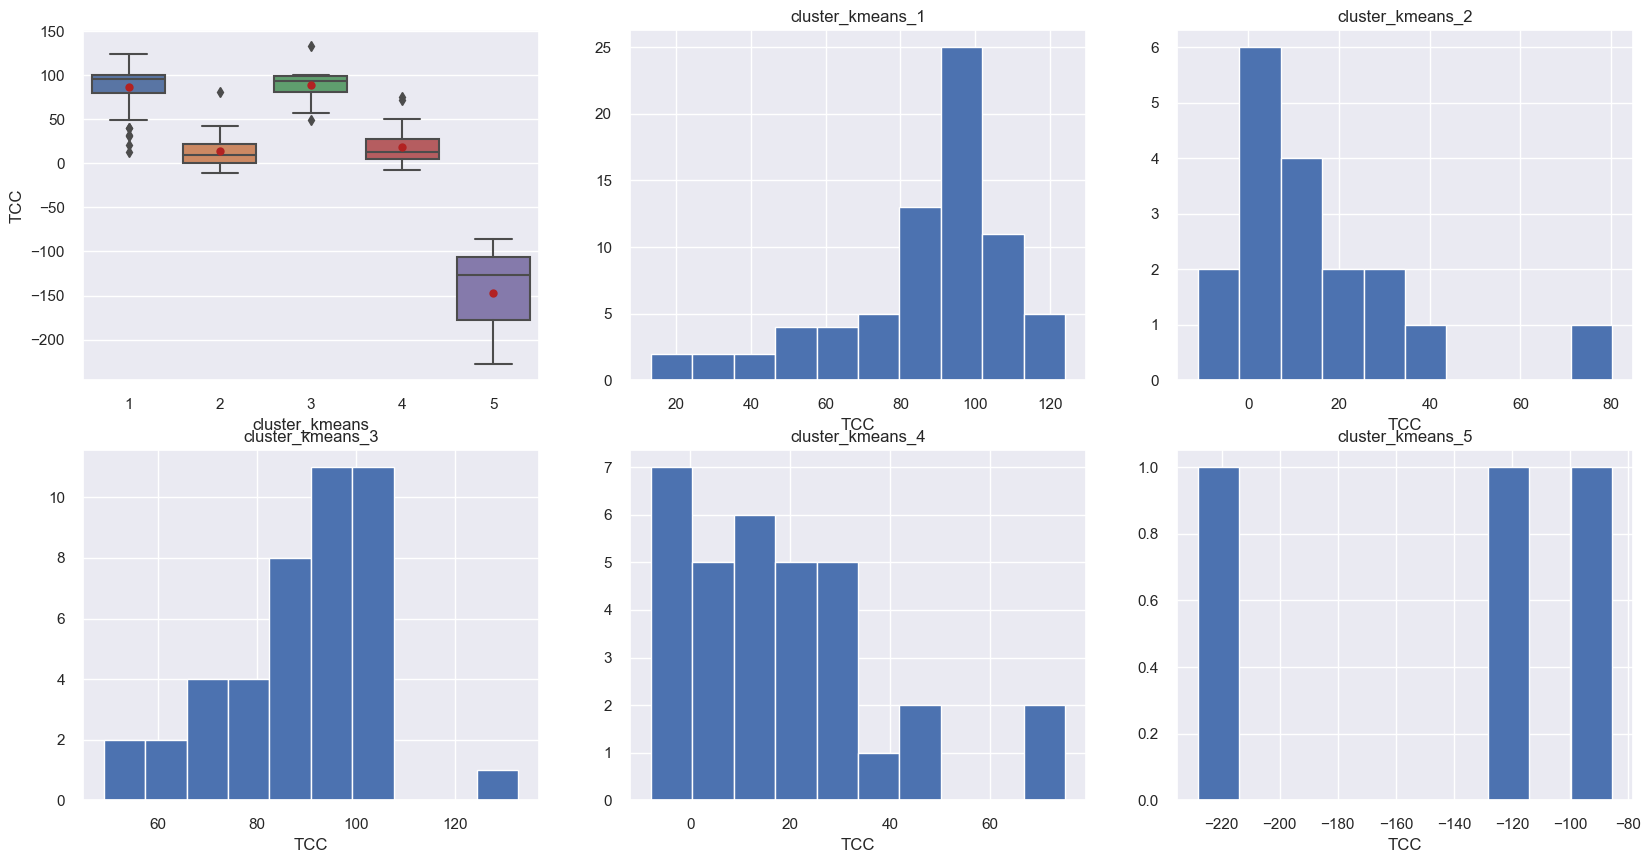

------------------------------------------------------------------------------------------------------------------------
Variable TEX


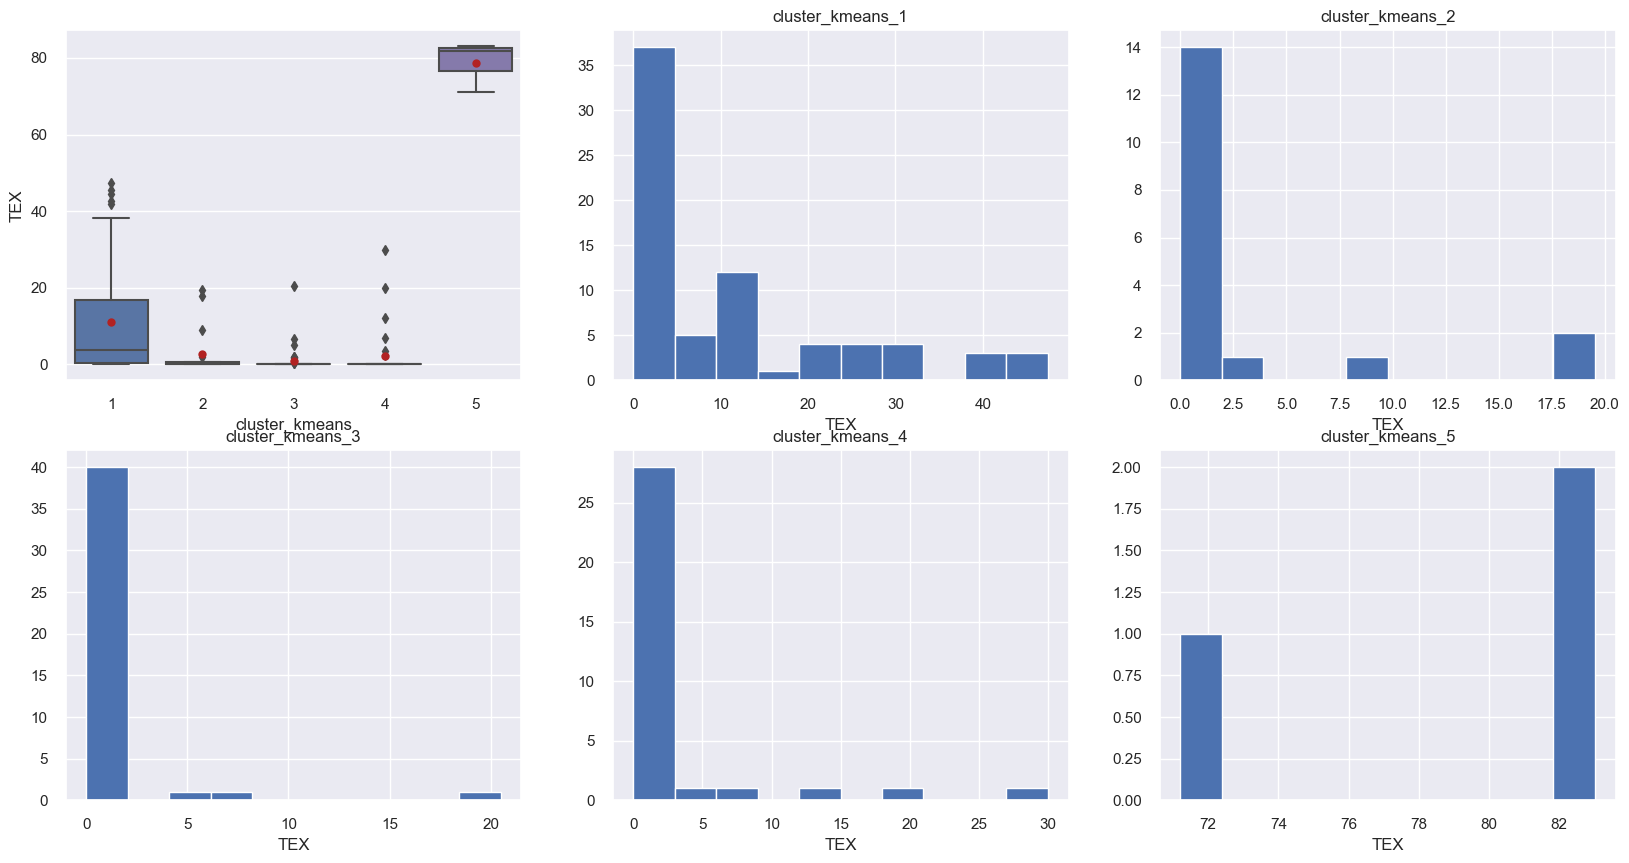

------------------------------------------------------------------------------------------------------------------------
Variable dispo_alim_(kg/pers/an)


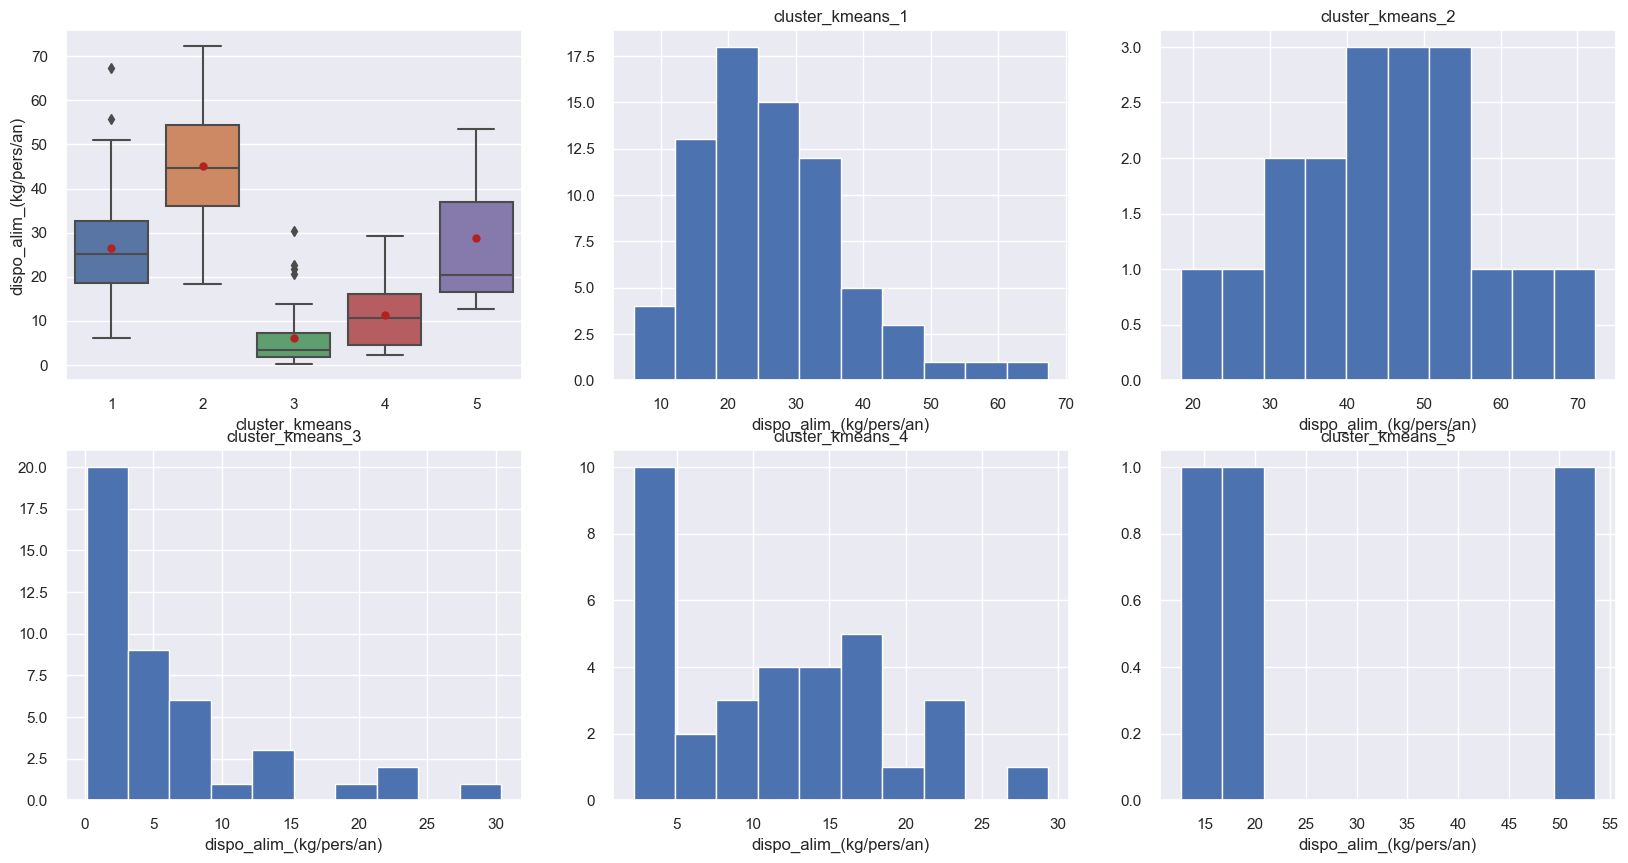

------------------------------------------------------------------------------------------------------------------------
Variable part_volaille_dispo_prot


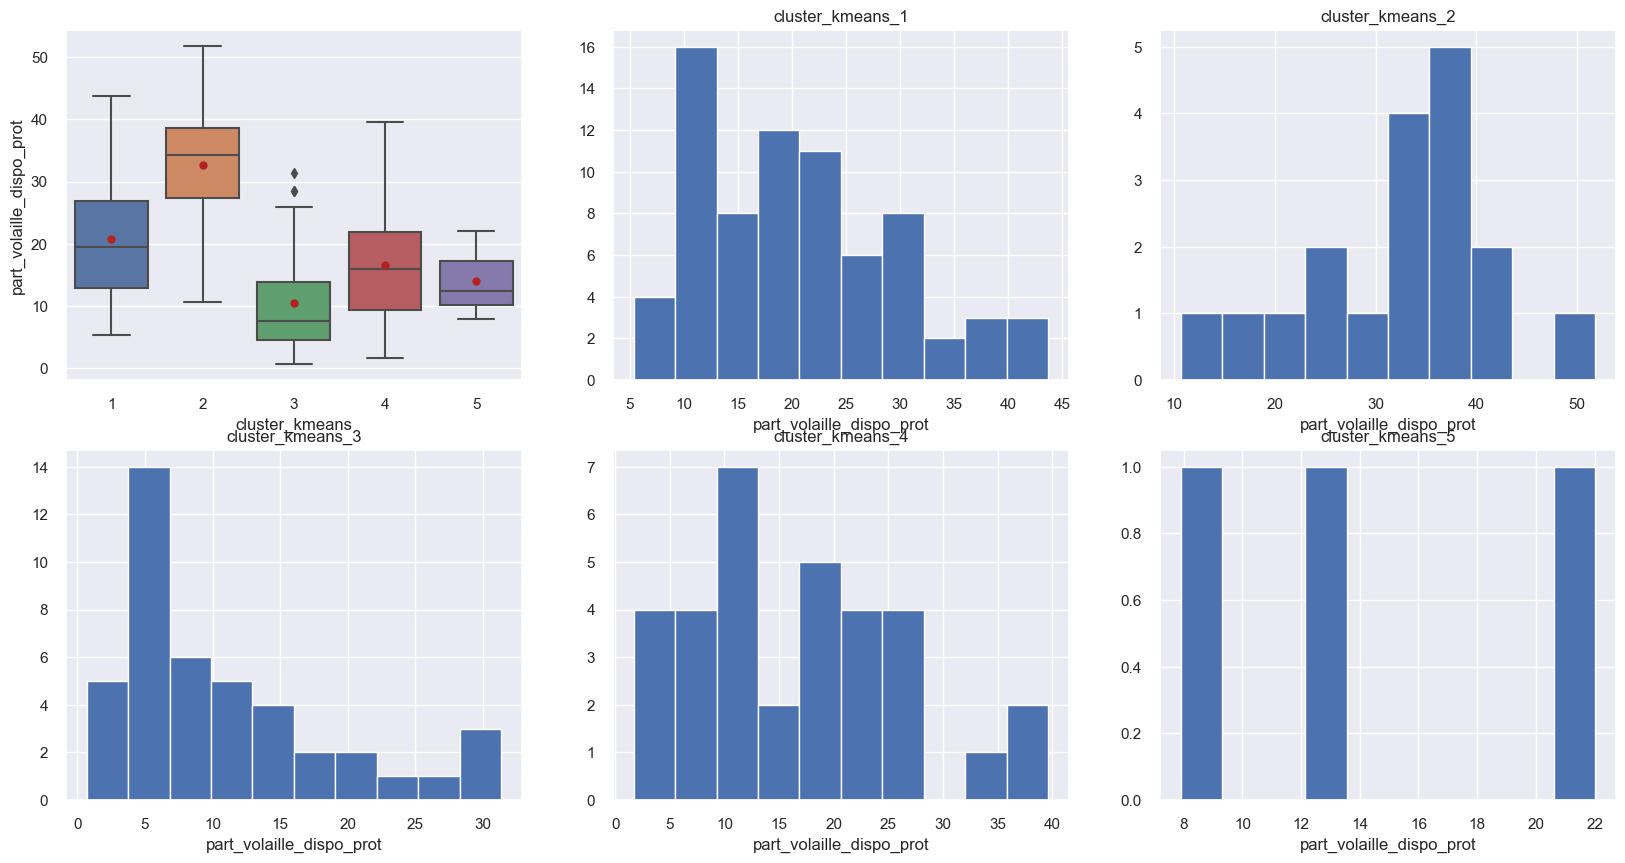

------------------------------------------------------------------------------------------------------------------------
Variable Evol_pop_sur_5ans_(%)


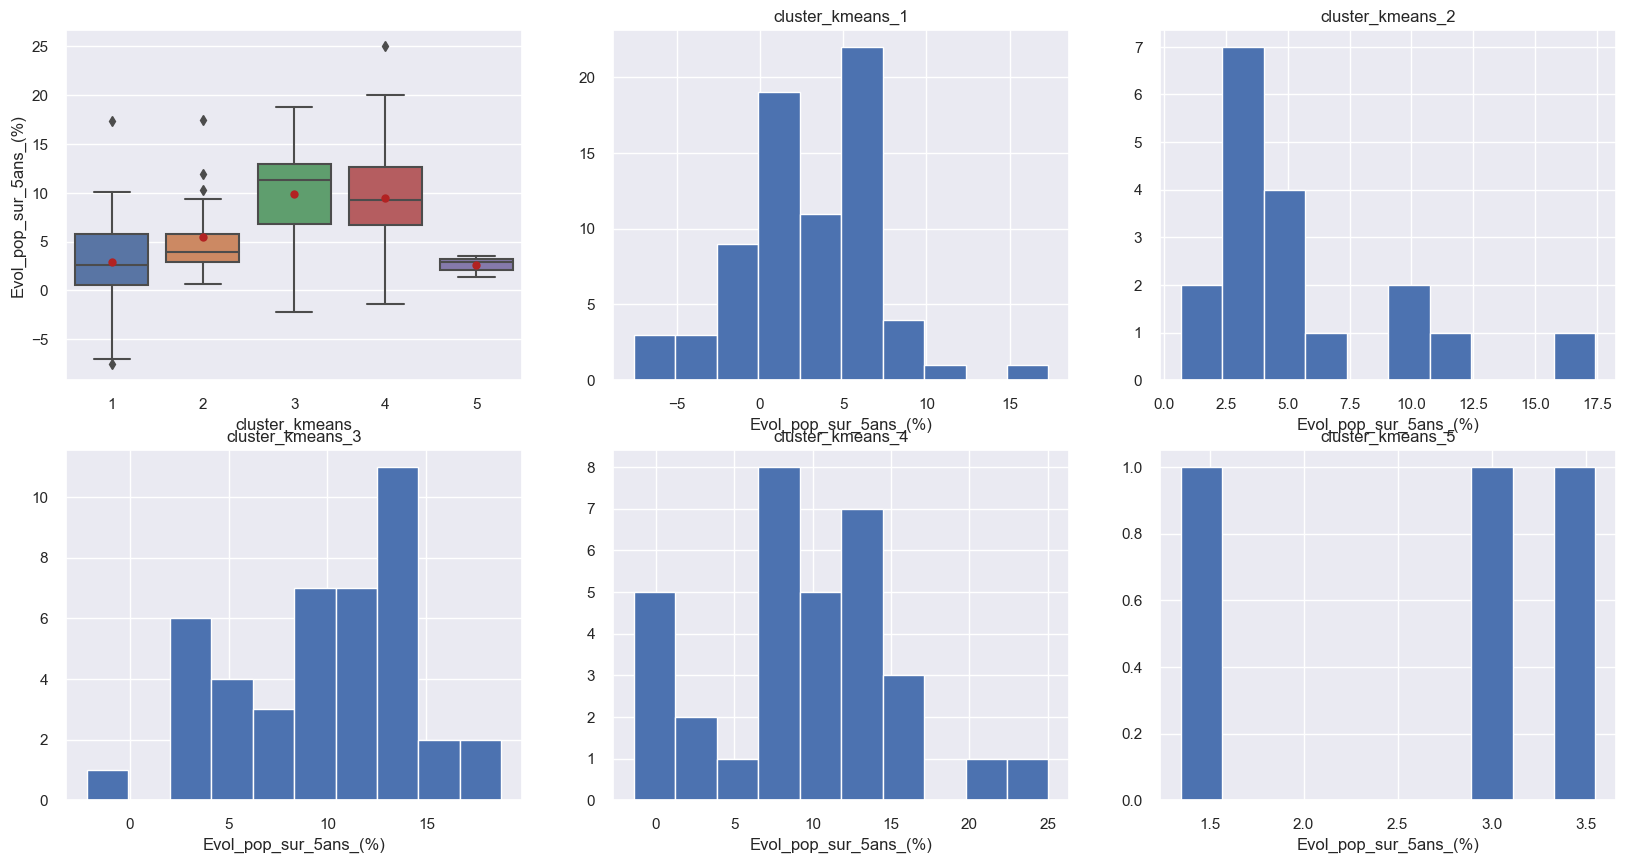

------------------------------------------------------------------------------------------------------------------------
Variable stabilite_politique


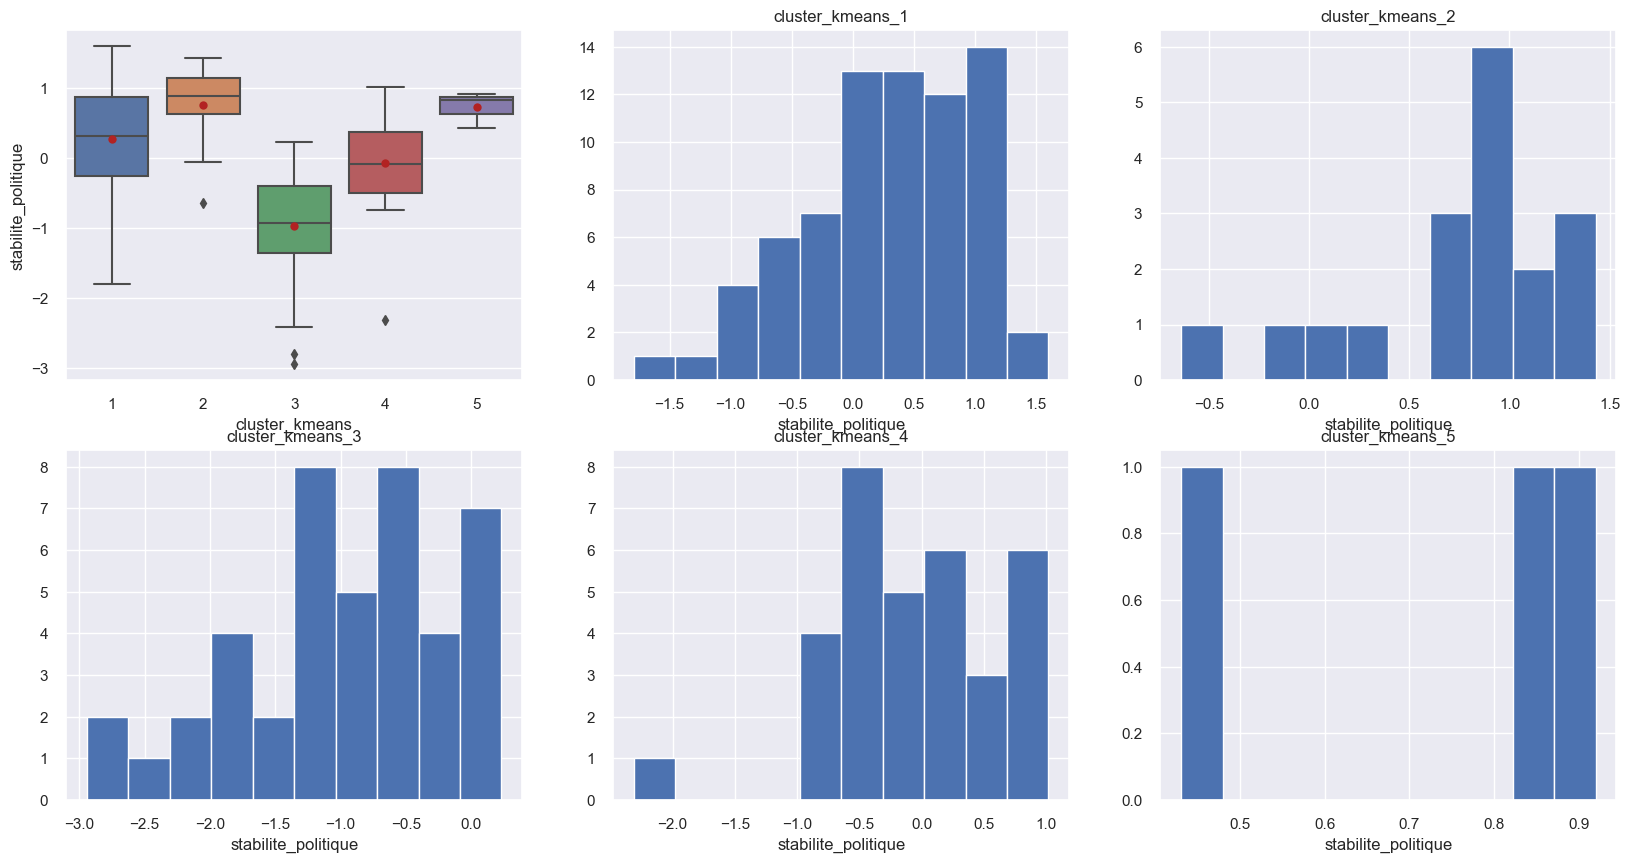

------------------------------------------------------------------------------------------------------------------------
Variable PIB_hab_($)


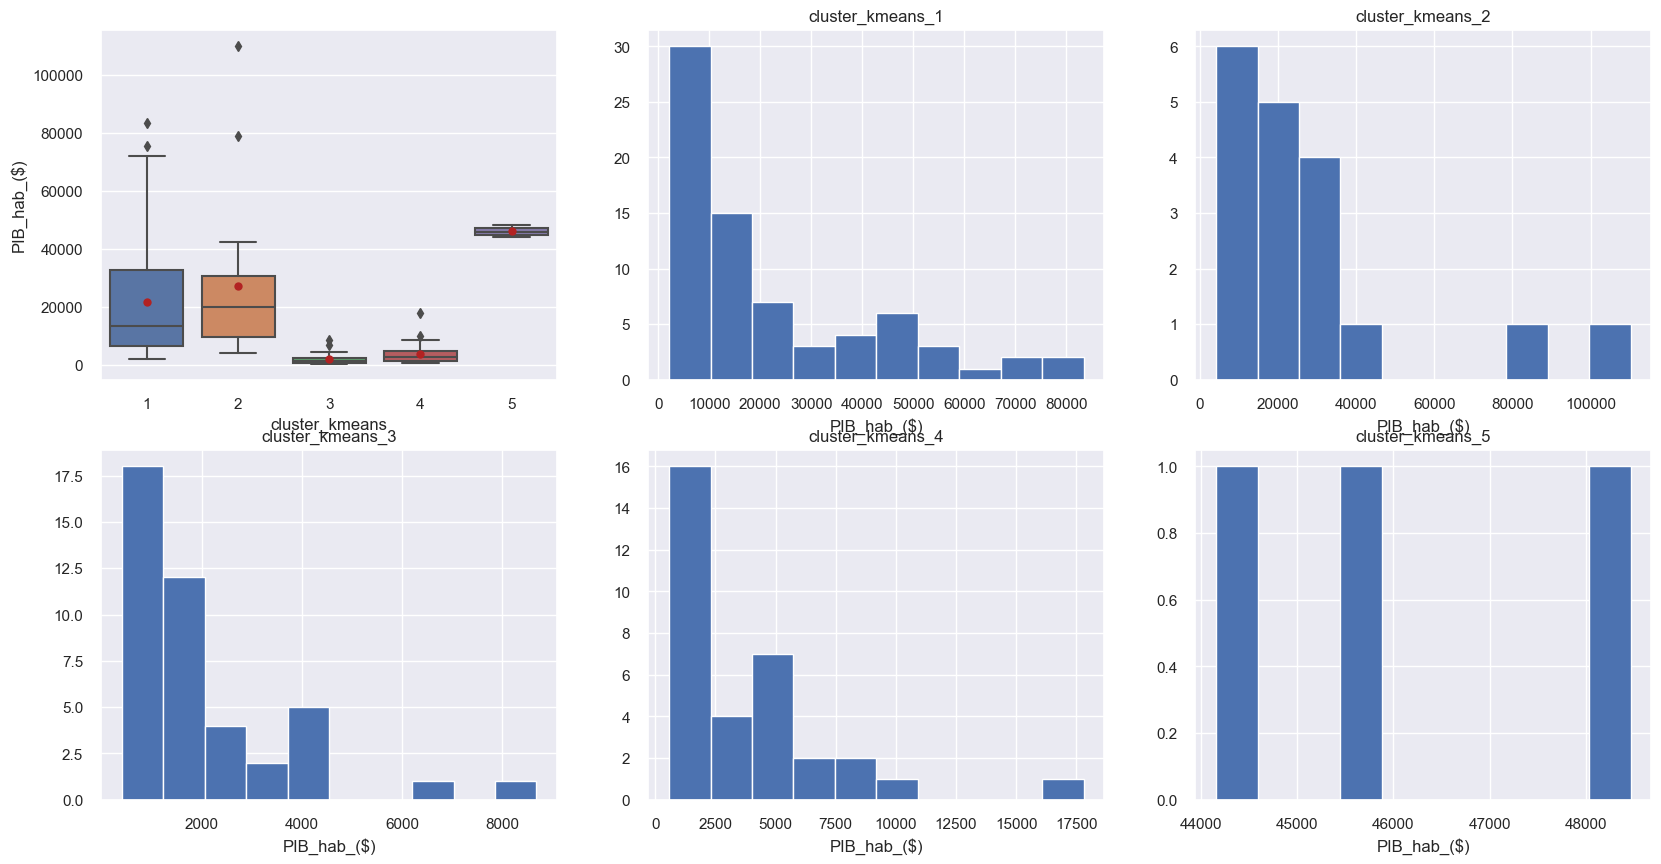

------------------------------------------------------------------------------------------------------------------------
Variable pop_ss_moyen_alim_saine_(%)


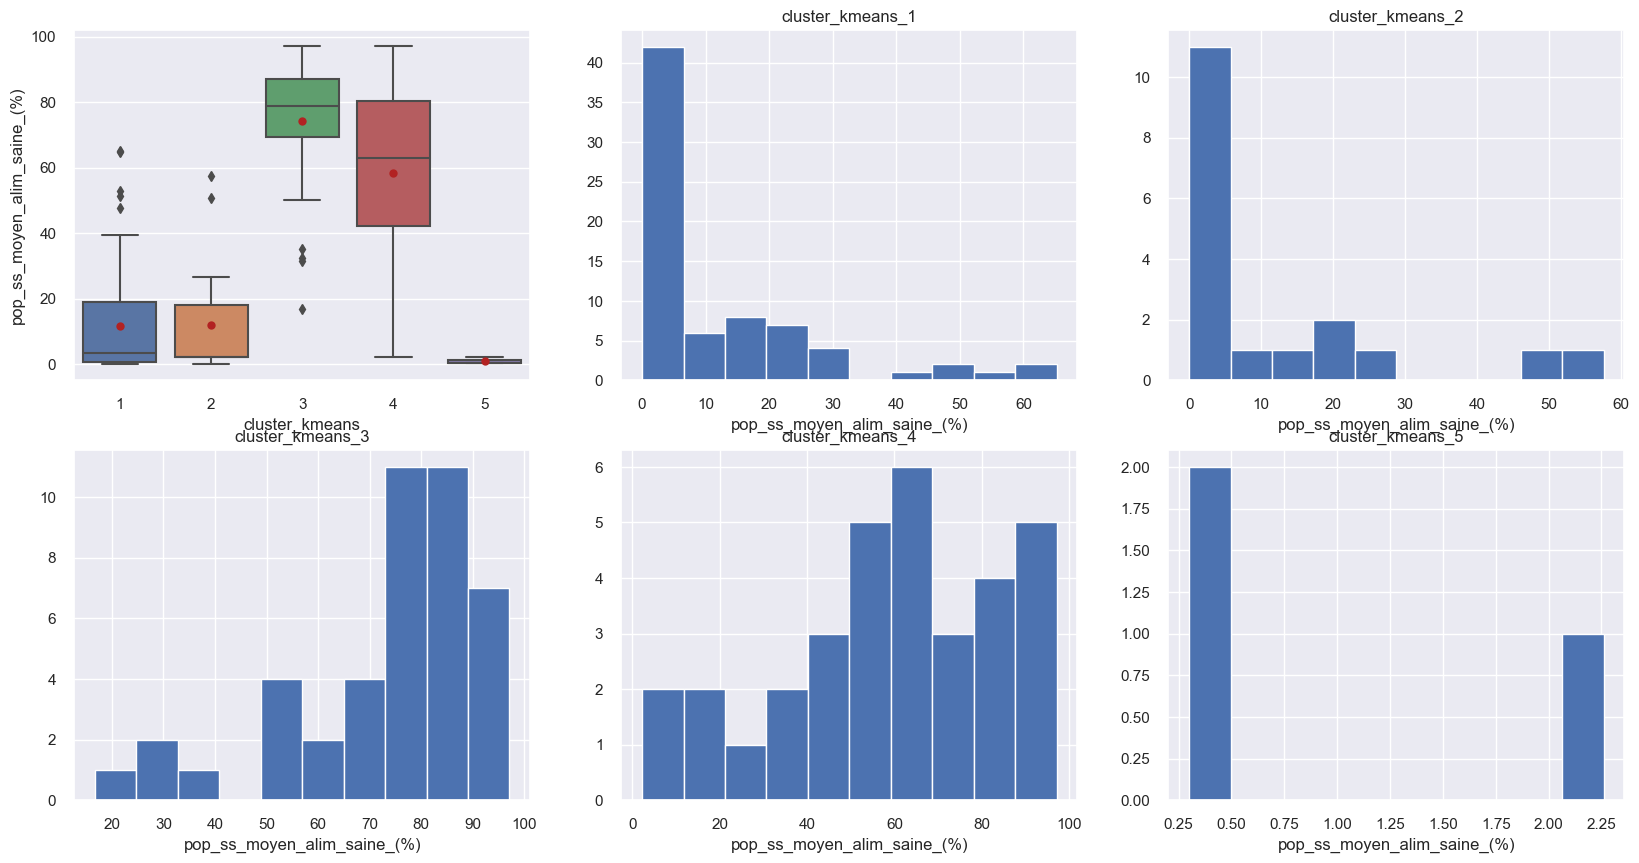

------------------------------------------------------------------------------------------------------------------------
Variable croissance_PIB_(%)


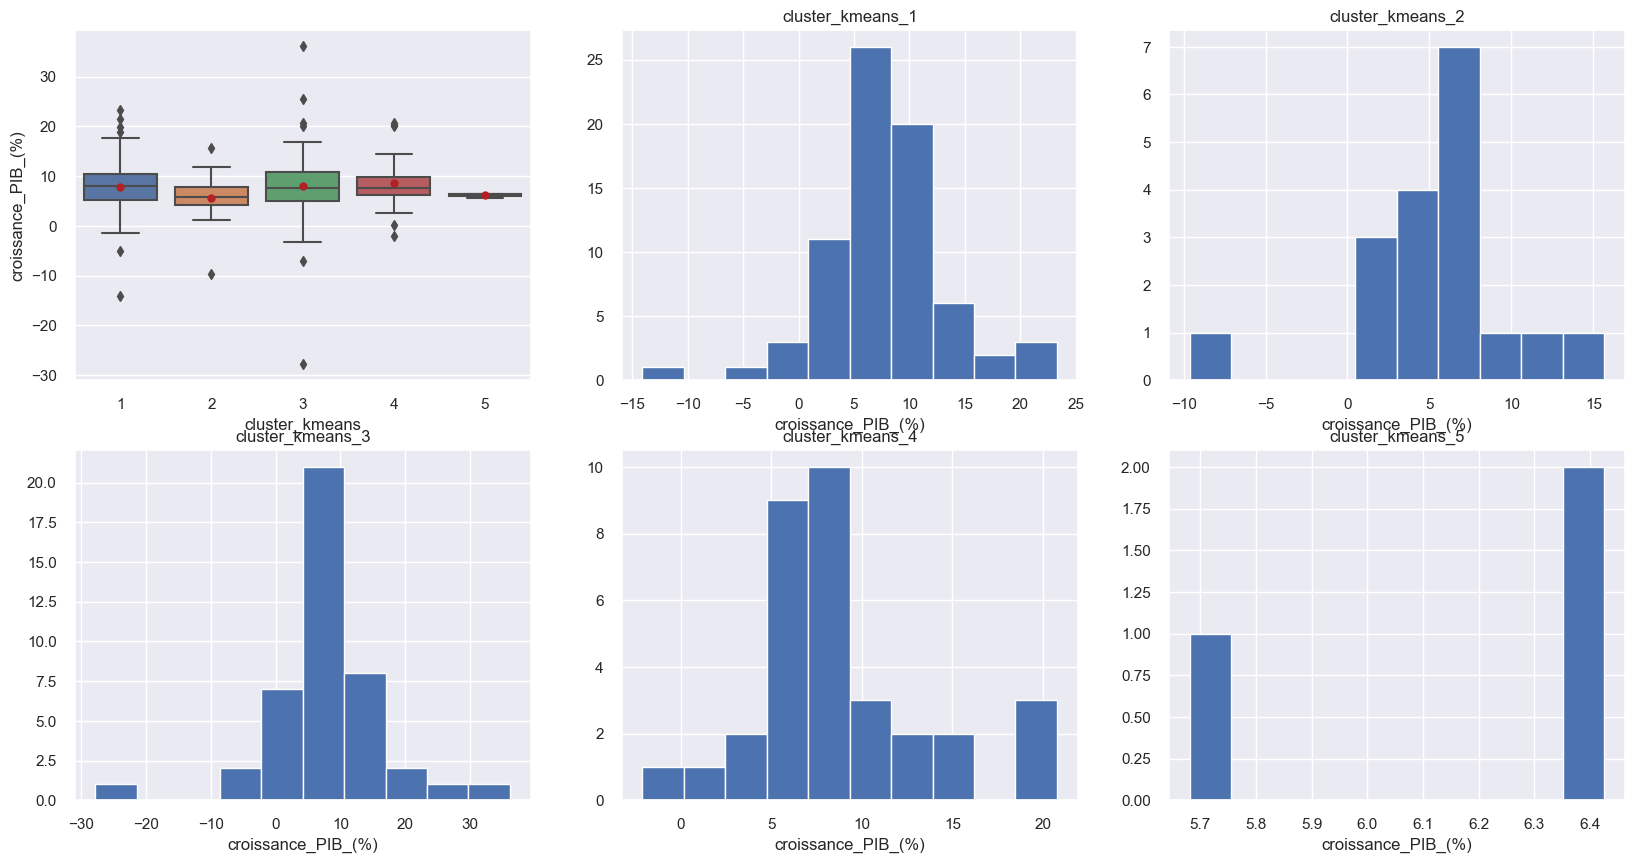

------------------------------------------------------------------------------------------------------------------------
Variable emission_CO2_hab


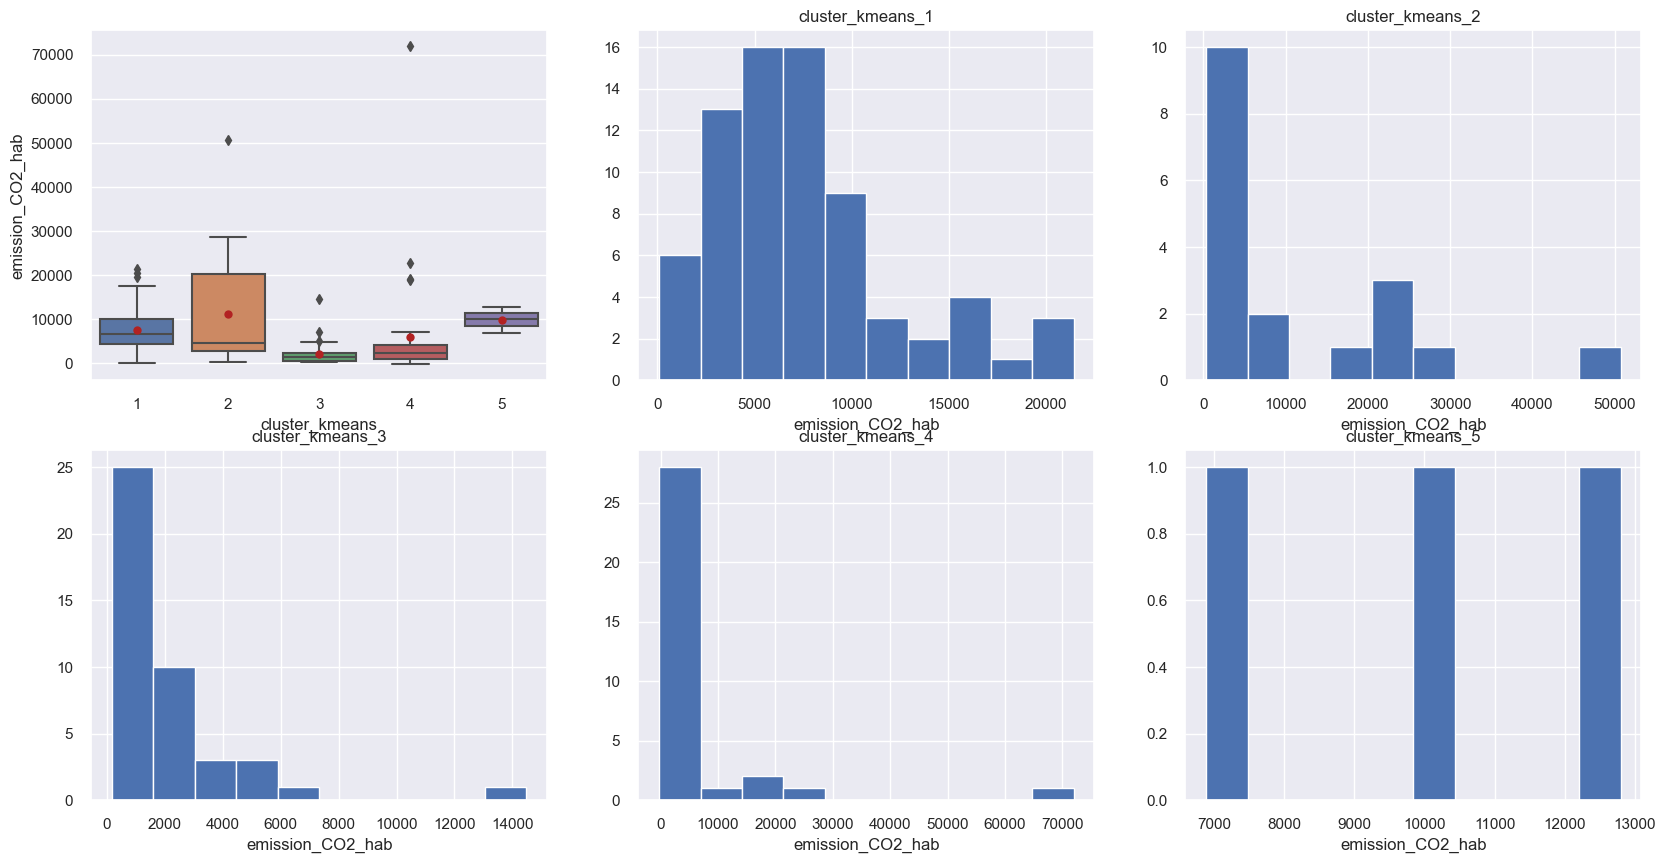

------------------------------------------------------------------------------------------------------------------------
Variable pop_log


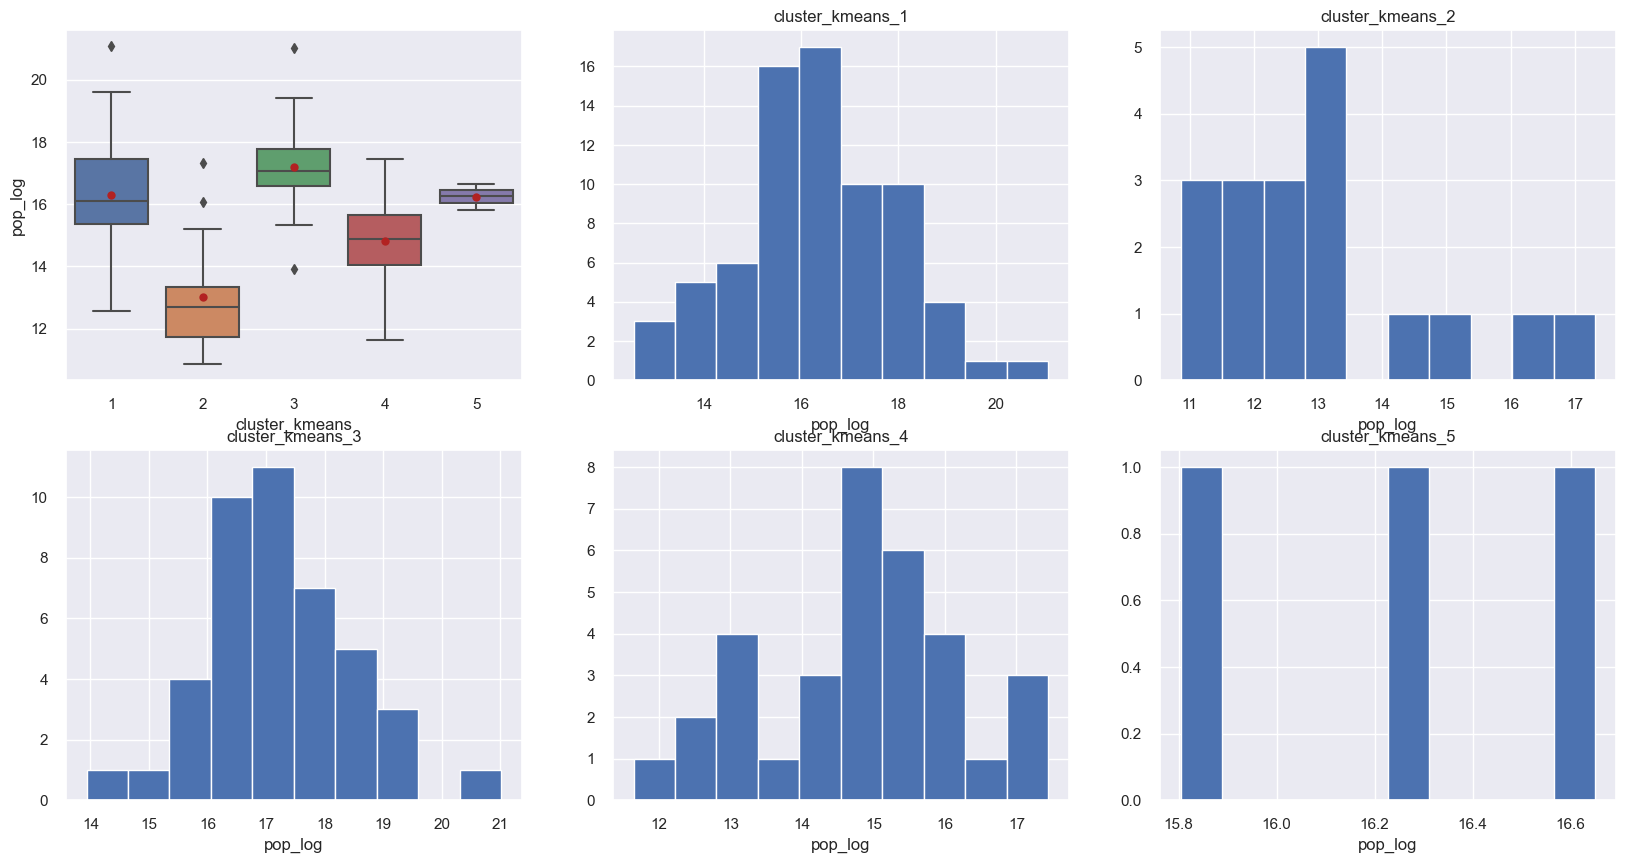

In [68]:
# Histogramme par cluster et par variable
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
    
for col in list(df_kmeans.columns[:14]):
    print('-'*120)
    print('Variable '+str(col))
    fig, ax = plt.subplots(2, 3, figsize=(20,10))
    sns.boxplot(data=df_kmeans, x='cluster_kmeans', y=col, ax=ax[0,0],showmeans=True, meanprops=meanprops)
    for i in range(1,k+1):
        q,mod = divmod(i,3)
        ax[q, mod].hist(df_kmeans.loc[df_kmeans['cluster_kmeans']==i,col])
        ax[q, mod].set_title('cluster_kmeans_'+str(i))
        ax[q, mod].set_xlabel(col)

    plt.show()

Afin d'identifier au sein du cluster 5 , le pays qui importe plus qu'il n'exporte, la variable balance import-export est ajoutée.

In [69]:
# Ajout de la variables balance import/export
df_complet_ok = df_complet_ok.assign(
    balance_import_export_kt = df_complet_ok['importations_(kt)']-df_complet_ok['exportations_(kt)'])

In [70]:
# Cible potentiel du cluster 1
df_complet_ok.loc[(df_complet_ok['cluster_kmeans']==5)\
                  &(df_complet_ok['balance_import_export_kt']>0),\
                        ['c_zone',
                         'zone',
                         'cluster_kmeans',
                         'TAS', 
                        'TDI',
                        'TDC',
                        'TCC',
                        'TEX',
                        'dispo_alim_(kg/pers/an)',
                        'part_volaille_dispo_prot',
                        'pop_2017', 
                        'Evol_pop_sur_5ans_(%)',
                        'stabilite_politique', 
                        'PIB_hab_($)',
                        'pop_ss_moyen_alim_saine_(%)',
                        'croissance_PIB_(%)', 
                        'emission_CO2_hab',
                        'balance_import_export_kt']]

c_zone                      zone  cluster_kmeans   TAS     TDI     TDC  \
140      96  Chine - RAS de Hong-Kong               5  8.57  323.93 -315.36   

        TCC    TEX  dispo_alim_(kg/pers/an)  part_volaille_dispo_prot  \
140 -228.21  71.21                    53.51                     22.02   

      pop_2017  Evol_pop_sur_5ans_(%)  stabilite_politique   PIB_hab_($)  \
140  7306322.0               3.551363                 0.83  45737.483212   

     pop_ss_moyen_alim_saine_(%)  croissance_PIB_(%)  emission_CO2_hab  \
140                         2.26            6.361267           6891.04   

     balance_import_export_kt  
140                     244.0

### 3.5. Résumé de l'analyse des clusters <a class="anchor" id="5_3_5">

* **Cluster 1 : 73 pays - 50% de la population mondiale**
    * composé majoritairement de pays d'Europe et d'Amériques
    * contient la majorité des pays d'Europe et d'Amériques
    * autosuffisant en volaille (TSA > 100% pour 50% des pays), exportateurs de volaille (TEX = 10%)
    * avec une faible dépendance aux importations (TDI<50% pour 75% des pays)
    * Consommateurs de volaille (part de la volaille dans la dispo totale en protéine d'origine animale élevé)
    * PIB par habitant élevé, alimentation saine abordable
    * stable politiquement
    * population pays moyenne
        
* **Cluster 2 : 18 pays - 0.7% de la population mondiale**
    * composé majoritairement  d'îles
    * dépendance aux importations (TAS < 20%, TDI proche de 100%)
    * peu ou pas d'exportations (TEX <5%)
    * PIB par habitant moyen, alimentation saine abordable
    * Consommateurs de volaille (part de la volaille dans la dispo totale en protéine d'origine animale élevé)
    * forte émission de CO2 par habitant
    * stable politiquement
    * faible population
        
* **Cluster 3 : 43 pays - 45% de la population mondiale**
    * composé de pays d'Afrique et d'Asie
    * contient la majorité des pays d'Afrique 
    * peu d'importations, autosuffisant en volaille
    * PIB par habitant très faible, alimentation saine peu abordable
    * très faible dispo alimentaire, consomme peu de volaille (faible part de la volaille dans la dispo totale en protéine d'origine animale)
    * instable politiquement
    * population importante et en croissance

* **Cluster 4 : 33 pays - 2.8% de la population**
    * composé majoritairement de pays d'Afrique et d'Asie 
    * pays dépendant des importations, non autosuffisant en volaille (TAS <20%, TDI élevé)
    * peu ou pas d'exportations (TEX <5%)
    * PIB par habitant très faible, alimentation saine peu abordable
    * stabilité politique moyenne (proche de 0)
    * population faible, population en croissance 
    * croissance PIB importante
    
* **Cluster 5 : 3 pays - 0.5% de la population mondiale**
    * composé que de pays d'Europe et d'Asie
    * pays qui réalisent de l'import /export de volaille (TEX et TDI très élevés, TCC négatif)
    * autosuffisant en volaille (TAS = 200%)
    * PIB par habitant trés élevé
    * stable politiquement
 

## <font color='green'>4. Conclusion et recommandations<a class="anchor" id="5_4"></a></font>

###### Caractérisation des clusters : 
* Cluster 1 = pays riches (à revenu moyen supérieur et haut), autosuffisants ou faible dépendance aux importations
* Cluster 2 : pays à revenu moyen superieur et haut, très dépendants des importations
* Cluster 3 = pays instables, à faible/moyen revenu, autosuffisant en volaille 
* Cluster 4 = pays à faible/moyen revenu, très dépendants des importations
* Cluster 5 = pays qui font de l'import / export, stables et à revenu moyen supérieur, 1 pays sur les 3 non autosuffisant

##### Cibles : 
* Le cluster 2 est recommandé pour l'exportation des volailles ainsi que Hong-Kong inclus dans le cluster 5 

In [71]:
pays_cibles_df = df_complet_ok.loc[(df_complet_ok['cluster_kmeans']==2)|\
                  (df_complet_ok['cluster_kmeans']==5)&(df_complet_ok['balance_import_export_kt']>0)]

In [72]:
# Liste des pays cibles 
pays_cibles_df['zone'].to_list()

['Suriname',
 'Arabie saoudite',
 'Émirats arabes unis',
 'Koweït',
 'Chine - RAS de Hong-Kong',
 'Chine - RAS de Macao',
 'Antigua-et-Barbuda',
 'Bahamas',
 'Dominique',
 'Grenade',
 'Sainte-Lucie',
 'Saint-Kitts-et-Nevis',
 'Saint-Vincent-et-les Grenadines',
 'Trinité-et-Tobago',
 'Malte',
 'Luxembourg',
 'Nouvelle-Calédonie',
 'Polynésie française',
 'Samoa']

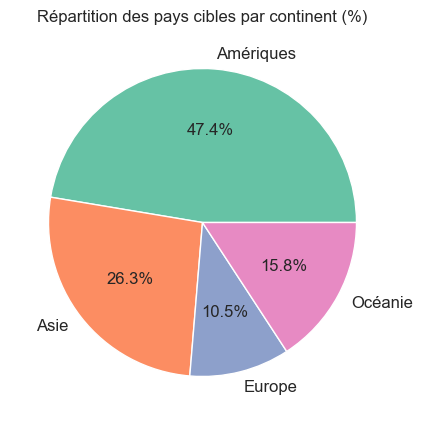

In [73]:
# Répartition des pays cibles par continent (%)
data = pays_cibles_df.groupby('continent')['zone'].count().reset_index()

plt.figure(figsize=(10,5))
plt.pie(x=data['zone'],                                   
        colors = sns.color_palette("Set2"),
        labels = data['continent'],
        autopct='%.1f%%',
        textprops={'fontsize': 12})
plt.title("Répartition des pays cibles par continent (%)")                                                                                          
plt.show()

##### Next steps

* Autres pays cibles : Une analyse plus poussée pourrait être réalisée sur les clusters 1 et 4 pour identifier d'autres pays cibles (classification réalisée sur ces clusters uniquement) : 
   * cluster 1: de gros importateurs font partie de ce cluster : Allemagne, Mexique, Japon, Royaume-Uni
   * cluster 4: contient des pays stables qui pourraient être une cible pour des poulets à bas prix 

* Pour l'étude de marché :
    * la distance des pays par rapport à la France pourrait être considérée pour le coût de transport, la problématique de conservation d'un produit frais et l'impact écologique.
    * la présence ou non d'accord de libre-échange peut être également un critère de l'analyse

* Visualisation : Tableau Software pourrait être utilisé pour la visualisation et la suite de l'étude de marché.